# COTS

Inpiration from AWSAF, a great work introducing yolov5
website: https://www.kaggle.com/code/awsaf49/great-barrier-reef-yolov5-train/notebook

# Environment
**It is recommended to run in Kaggle**

**with best.pt as import file**

tensorflow-great-barrier-reef data can be added easily in kaggle

# Run training
**run all before "prepare for inference"**

# Run inference
**run library, run install yolov5 then run all after including
"prepare for inference"**

# Download YOLOv5

**YOLO**(YOU ONLY LOOK ONCE) is quick and simple for object detection, it is also a one stage detector.

From the high level object detection architecture, yolov5 comprises of input, backbone, neck and head which is dense prediction for yolo.

In yolov5, it uses CSPDarknet53 for its backbone and SPP block to seperate the critical features without sacrificing the network computational speed. PANet is utilised for its neck as parameter aggregation from various backbone levels. It uses YOLOv3 for its head.

Self-Adversarial Training (SAT) ,Mosaic data augmentation was introduced in yolov5, it mixes four training images. 

Furthermore, existing modules such as Spatial Attention Module (SAM), PAN and CBN have been adjusted to improve the overall performance of these modules.

# Intall yolov5

In [1]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -qr requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 15033, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 15033 (delta 45), reused 63 (delta 40), pack-reused 14960
Receiving objects: 100% (15033/15033), 13.64 MiB | 30.03 MiB/s, done.
Resolving deltas: 100% (10386/10386), done.
/kaggle/working/yolov5


In [2]:
import os
import sys
import cv2
import shutil
import wandb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import ast
import albumentations as albu
import yaml
import copy
from IPython.display import display
from tqdm.notebook import tqdm
tqdm = tqdm.pandas()
from PIL import Image

from sklearn.model_selection import GroupKFold
from yolov5 import utils
display = utils.notebook_init()


YOLOv5 🚀 v6.2-243-g5e03f5f Python-3.7.12 torch-1.11.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)


Setup complete ✅ (2 CPUs, 15.6 GB RAM, 3964.5/4030.6 GB disk)


# Weights and Biases
**no W&B account skip this step**

W&B is a powerful tool to retrieve the results such as F1 score, confusion matrix, P and R curves, validation images sample. It can track and compare each training.

In [3]:
# from kaggle_secrets import UserSecretsClient
# user_secrets = UserSecretsClient()
# secret_value_0 = user_secrets.get_secret("user_secret")

# ! wandb login $secret_value_0

# Data Preprocessing

In [4]:
# create directories
!mkdir -p '/kaggle/working/images' # to store training images
!mkdir -p '/kaggle/working/labels' # to store labels of images

# for paths
img_path = '/kaggle/working/images'
label_path = '/kaggle/working/labels'
input_path = '/kaggle/input/tensorflow-great-barrier-reef/train_images'

# check
print('path:', os.listdir('/kaggle/working/'))

path: ['labels', '__notebook_source__.ipynb', 'images', '.virtual_documents', 'yolov5']


In [5]:
# import data
data = pd.read_csv('/kaggle/input/tensorflow-great-barrier-reef/train.csv')

# get number of images
# data['annotations'] = data['annotations'].progress_apply(eval)
# data.sample(3)
data['bbox_nums'] = data['annotations'].progress_apply(lambda x: str.count(x, 'x'))

# get number of images with box
data = data[data['bbox_nums']>0]
# data.sample(2)
print('num of images with bbox:', (data['bbox_nums']>0).count())

# get train data by removing images with no bbox
train_data = data[data['bbox_nums']>0].reset_index(drop=True)

# get path of input, new image path and new label path
train_data['input_path'] = input_path + '/video_' + \
                            train_data['video_id'].astype(str) + \
                            '/' + train_data['video_frame'].astype(str) + \
                            '.jpg'
train_data['image_path'] = '/kaggle/working/images/video_' + \
                            train_data['video_id'].astype(str) + \
                            '_' + train_data['video_frame'].astype(str) + \
                            '.jpg'
train_data['label_path'] = '/kaggle/working/labels/video_' + \
                            train_data['video_id'].astype(str) + \
                            '_' + train_data['video_frame'].astype(str) + \
                            '.txt'

# all images has same dim of 1280x720 (wid, height)
train_data['width'] = 1280
train_data['height'] = 720

# get coco bbox
# coco format: [x, y, wid, height]
# to get later yolo format: [x_center, y_c, wid, height]
train_data['bbox'] = train_data['annotations'].apply(lambda x: [list(annot.values()) \
                                                    for annot in eval(x)])
train_data.sample(2)


  0%|          | 0/23501 [00:00<?, ?it/s]

num of images with bbox: 4919


video_id  sequence  video_frame  sequence_frame image_id  ...  \
2279         1     15827         1984              66   1-1984  ...   
3565         1     17665         6909              64   1-6909  ...   

                                   image_path  \
2279  /kaggle/working/images/video_1_1984.jpg   
3565  /kaggle/working/images/video_1_6909.jpg   

                                   label_path width height  \
2279  /kaggle/working/labels/video_1_1984.txt  1280    720   
3565  /kaggle/working/labels/video_1_6909.txt  1280    720   

                                                   bbox  
2279                                [[1033, 0, 37, 33]]  
3565  [[461, 649, 71, 65], [570, 484, 58, 52], [630,...  

[2 rows x 13 columns]

# Write images and labels

**Write images in output files**

Images are copied from ../input/tensorflow-great-barrier-reef/train_images to newly created images file.

utilization of shutil library to copy

In [6]:
# store images in new folder (image file created above)
for i in train_data['input_path'].tolist():
    dash = i.split('/')
    
    # last and 2nd last from path is video frame and id
    video_id = dash[-2]
    video_frame = dash[-1]
    
    # copy images from input path to new folders
    image_path = f'/kaggle/working/images/{video_id}_{video_frame}'
    shutil.copy(src=i, dst=image_path)
print('success')

success


get few images from images folder： video_1_9378.jpg
(1280, 720)


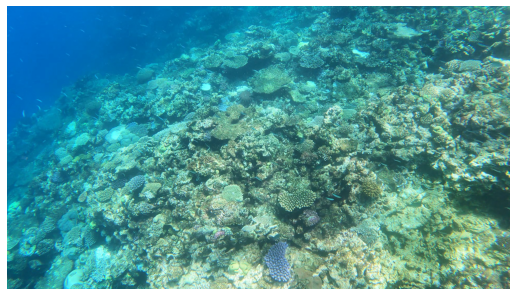

In [7]:
# test
print('get few images from images folder：', 
     os.listdir(img_path)[6])

# plt.figure(1)
img = Image.open('/kaggle/working/images/video_1_8822.jpg')
# image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY )
plt.figure(figsize=(9,9))
plt.imshow(img)
plt.axis('off')
print(img.size)

# Coco2Yolo labels
It is neccessary to convert the coco format to yolo. 

from coco format: [x, y, wid, height]
to yolo format: [x_center, y_c, wid, height]

In [8]:
# normalize and then convert coco2yolo
# information and formula obtained from:
# https://prabhjotkaurgosal.com/weekly-learnings/weekly-learning-blogs/

# bbox is the coco box
# image width and height to process
def coco2yolo(bbox, img_wid, img_height):
    
    # convert to float type
    bbox = np.array(bbox).astype(float)
    
    # normalize the dimension
    # start from the width (x and wid)
    bbox[:, [0,2]] = bbox[:, [0,2]] / img_wid
    # then deal with height (y and height)
    bbox[:, [1,3]] = bbox[:, [1,3]] / img_height
    
    # convert the x,y to x_center, y_center
    # as written in the website the formula for conversion:
    bbox[:, [0,1]] = bbox[:, [0,1]] + bbox[:, [2,3]] / 2
    
    # keep the values between 0-1
    bbox = np.clip(bbox, a_min=0, a_max=1)
    
    return bbox
    

In [9]:
# test bbox conversion
box_test = [[576,407,75,72],[872,531,27,36]]

print('coco2yolo:', coco2yolo(img_wid=1280, 
                             img_height=720,
                             bbox=box_test))

coco2yolo: [[     0.4793     0.61528    0.058594         0.1]
 [     0.6918      0.7625    0.021094        0.05]]


**Write labels in output files**
Same as images written above,
copy labels  from ../input/tensorflow-great-barrier-reef/train_images to newly created labels file.



In [10]:
# store labels in new folder
label_bbox = []
width = 1280
height = 720

# .iloc function to get row or column data
for j in range(train_data.shape[0]):
    row_data = train_data.iloc[j]
    img_wid = row_data.width
    img_height = row_data.height
    bbox = np.array(row_data.bbox).astype(np.float32).copy()
    num_bbox = row_data.bbox_nums
    
    # form yolo annotation by creating file
    # and write labels
    with open(row_data.label_path, 'w') as file:
        if num_bbox < 1:
            file.write('')
            continue
            
        # convert all the labels from coco2yolo
        yolo_box = coco2yolo(bbox, width, height)
        label_bbox.append(yolo_box)
        
        # write labels in new file
        for k in range(num_bbox):
            
            label = ['0'] + \
                    yolo_box[k].astype(str).tolist() + \
                    ([''] if k+1 == num_bbox else ['\n'])
            label = ' '.join(label).strip('')
            file.write(label)
print('success')           

success


In [11]:
# test
print('check labels folder:', os.listdir('/kaggle/working/labels')[:2],'\n')

txt1 = open('/kaggle/working/labels/video_1_5714.txt', 'r')
txt2 = open('/kaggle/working/labels/video_0_9516.txt', 'r')

print('txt1:\n' + txt1.read() + '\n')
print('txt2:\n' + txt2.read() + '\n')


check labels folder: ['video_0_1898.txt', 'video_1_9367.txt'] 

txt1:
0 0.8089843750000001 0.8625 0.04921875 0.06111111111111111 
0 0.759765625 0.8090277777777778 0.04765625 0.07361111111111111 
0 0.58046875 0.9375 0.0484375 0.06944444444444445 

txt2:
0 0.0515625 0.36944444444444446 0.05 0.06111111111111111 



# YOLOv5

**Splitting data**
Data is split into 2 parts: training and testing sections.

！！！can edit how to split

    data has 3 video: video_0, video_1, video_2
    
*     train: images from video_0, video_1 (2099+677)
*     validate: images from video_2 (2143)


In [12]:
# split images for training and validating
train = train_data[train_data['video_id'].isin([1,2])]
validate = train_data[train_data['video_id'].isin([0])]

# get images and labels
# train
train_img = list(train['image_path'])
train_lab = list(train['label_path'])

# validate/test
validate_img = list(validate['image_path'])
validate_lab = list(validate['label_path'])

# test the items in each data sets
print('train:', len(train), '\n'
     'validate:', len(validate), '\n')

train: 2776 
validate: 2143 



**Create train and validation directories to store train and validation data**

In [13]:
# train path
with open('/kaggle/working/train_img.txt', 'w') as file:
    for item in train_img:
        file.write(item + '\n')

# validate path
with open('/kaggle/working/valid_img.txt', 'w') as file:
    for item in validate_img:
        file.write(item + '\n')

**Configure yaml file for training**

In [14]:
data = {'path': '/kaggle/working',
        'train': '/kaggle/working/train_img.txt',
        'val': '/kaggle/working/valid_img.txt',
        'nc': 1,
        'names': ['cots']}

with open("/kaggle/working/data.yaml", 'w') as file:
    yaml.dump(data, file, default_flow_style=False)

# %cat /kaggle/working/yolov5/data/data.yaml
y = open(os.path.join('/kaggle/working', 'data.yaml'), 'r')
print('yaml:', y.read())

yaml: names:
- cots
nc: 1
path: /kaggle/working
train: /kaggle/working/train_img.txt
val: /kaggle/working/valid_img.txt



**Set parameters**

In [15]:
Epochs = 1 # should be 12 or above
Batch_size = 4
Img_size = 1280

**Change some hyperparameters**
change some of hyperparameters in default
Inspiration from：
https://www.kaggle.com/c/tensorflow-great-barrier-reef/discussion/307760
* mosaic prob = 0.25
* mixup prob = 0.25
* rotation = +/-90deg

However, default parameters are more suitable and stable to run.

In [16]:
%%writefile /kaggle/working/hyper.yaml
lr0: 0.01  # initial learning rate (SGD=1E-2, Adam=1E-3)
lrf: 0.1  # final OneCycleLR learning rate (lr0 * lrf)
momentum: 0.937  # SGD momentum/Adam beta1
weight_decay: 0.0005  # optimizer weight decay 5e-4
warmup_epochs: 3.0  # warmup epochs 
warmup_momentum: 0.8  # warmup initial momentum
warmup_bias_lr: 0.1  # warmup initial bias lr
box: 0.05  
cls: 0.5 
cls_pw: 1.0
obj: 1.0  
obj_pw: 1.0  
iou_t: 0.20  
anchor_t: 4.0  # anchor-multiple threshold
# image adjustment
fl_gamma: 0.0
hsv_h: 0.015
hsv_s: 0.7
hsv_v: 0.4
degrees: 90.0  # image rotation
translate: 0.10
scale: 0.5
shear: 0.0
perspective: 0.0
flipud: 0.5
fliplr: 0.5
mosaic: 0.25  # image mosaic (probability)
mixup: 0.25 # image mixup (probability)
copy_paste: 0.0

Writing /kaggle/working/hyper.yaml


In [17]:
!python /kaggle/working/yolov5/train.py --img {Img_size}\
                 --batch {Batch_size}\
                 --optimizer 'Adam'\
                 --epochs {Epochs}\
                 --data /kaggle/working/data.yaml\
#                  --hyp /kaggle/working/hyper.yaml\
                 --weights yolov5s6.pt
                 --exist-ok

wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 
wandb: W&B disabled due to login timeout.
train: weights=yolov5s.pt, cfg=, data=/kaggle/working/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=1, batch_size=4, imgsz=1280, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=Adam, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.2-243-g5e03f5f Python-3.7.12 torch-1.11.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

hyperparameters: lr0=0.01, lrf=0.01, momen

# Prepare for inference

In [18]:
# split the into 5 folders for later inference
input_path = '/kaggle/input/tensorflow-great-barrier-reef/'

def get_bbox(annots):
    bboxes = [list(annot.values()) for annot in annots]
    return bboxes

def get_path(row):
    row['image_path'] = f'{input_path}/train_images/video_{row.video_id}/{row.video_frame}.jpg'
    return row


# import data
infer = pd.read_csv('/kaggle/input/tensorflow-great-barrier-reef/train.csv')

# get number of images
# data['annotations'] = data['annotations'].progress_apply(eval)
# data.sample(3)
infer['bbox_nums'] = infer['annotations'].progress_apply(lambda x: str.count(x, 'x'))

# Don't filter for annotated frames. Include frames with no bboxes as well!
infer_train = infer

# Annotations 
infer_train['annotations'] = infer_train['annotations'].progress_apply(lambda x: ast.literal_eval(x))
infer_train['bboxes'] = infer_train.annotations.progress_apply(get_bbox)

infer_train = infer_train.progress_apply(get_path, axis=1)

gkf = GroupKFold(n_splits = 5) 
infer_train = infer_train.reset_index(drop=True)
infer_train['folder'] = -1
for folder, (train_index, val_index) in enumerate(gkf.split(infer_train, y = infer_train.video_id.tolist(), groups=infer_train.sequence)):
    infer_train.loc[val_index, 'folder'] = folder

infer_train.head(3)

  0%|          | 0/23501 [00:00<?, ?it/s]

  0%|          | 0/23501 [00:00<?, ?it/s]

  0%|          | 0/23501 [00:00<?, ?it/s]

  0%|          | 0/23501 [00:00<?, ?it/s]

video_id  sequence  video_frame  sequence_frame image_id annotations  \
0         0     40258            0               0      0-0          []   
1         0     40258            1               1      0-1          []   
2         0     40258            2               2      0-2          []   

   bbox_nums bboxes                                         image_path  folder  
0          0     []  /kaggle/input/tensorflow-great-barrier-reef//t...       3  
1          0     []  /kaggle/input/tensorflow-great-barrier-reef//t...       3  
2          0     []  /kaggle/input/tensorflow-great-barrier-reef//t...       3

**bbox convert**

In [19]:
# Modified from https://www.kaggle.com/awsaf49/great-barrier-reef-yolov5-infer

#     confidence scores
def voc2yolo(bboxes, image_height=720, image_width=1280):
    """
    voc  => [x1, y1, x2, y1]
    yolo => [xmid, ymid, w, h] (normalized)
    """
    
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    bboxes[..., [0, 2]] = bboxes[..., [0, 2]]/ image_width
    bboxes[..., [1, 3]] = bboxes[..., [1, 3]]/ image_height
    
    width = bboxes[..., 2] - bboxes[..., 0]
    height = bboxes[..., 3] - bboxes[..., 1]
    
    bboxes[..., 0] = bboxes[..., 0] + width/2
    bboxes[..., 1] = bboxes[..., 1] + height/2
    bboxes[..., 2] = width
    bboxes[..., 3] = height
    
    return bboxes



def yolo2coco(bboxes, image_height=720, image_width=1280):
    """
    yolo => [xmid, ymid, w, h] (normalized)
    coco => [xmin, ymin, w, h]
    
    """ 
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    # denormalizing
    bboxes[..., [0, 2]]= bboxes[..., [0, 2]]* image_width
    bboxes[..., [1, 3]]= bboxes[..., [1, 3]]* image_height
    
    # converstion (xmid, ymid) => (xmin, ymin) 
    bboxes[..., [0, 1]] = bboxes[..., [0, 1]] - bboxes[..., [2, 3]]/2
    
    return bboxes

def voc2coco(bboxes, image_height=720, image_width=1280):
    bboxes  = voc2yolo(bboxes, image_height, image_width)
    bboxes  = yolo2coco(bboxes, image_height, image_width)
    return bboxes



def plot_one_box(x, img, score=None, color=None, label=None, line_thickness=None):
    # Plots one bounding box on image img
    tl = line_thickness or round(0.002 * (img.shape[0] + img.shape[1]) / 2) + 1  # line/font thickness
    color = color or [random.randint(0, 255) for _ in range(3)]
    c1, c2 = (int(x[0]), int(x[1])), (int(x[2]), int(x[3]))
    cv2.rectangle(img, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)
    if label:
        tf = max(tl - 1, 1)  # font thickness
        t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(img, c1, c2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(img, "{}:{:.2f}".format(label, score), (c1[0], c1[1] - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)

def draw_bboxes(img, bboxes, scores, classes, class_ids, colors = None, show_classes = None, bbox_format = 'yolo', class_name = False, line_thickness = 2):  
     
    image = img.copy()
    show_classes = classes if show_classes is None else show_classes
    colors = (0, 255 ,0) if colors is None else colors
    
    if bbox_format == 'yolo':
        
        for idx in range(len(bboxes)):  
            
            bbox  = bboxes[idx]
            cls   = classes[idx]
            cls_id = class_ids[idx]
            try:
                score = scores[idx]
            except:
                score = None
            color = colors[cls_id] if type(colors) is list else colors
            
            if cls in show_classes:
            
                x1 = round(float(bbox[0])*image.shape[1])
                y1 = round(float(bbox[1])*image.shape[0])
                w  = round(float(bbox[2])*image.shape[1]/2) #w/2 
                h  = round(float(bbox[3])*image.shape[0]/2)

                voc_bbox = (x1-w, y1-h, x1+w, y1+h)
                plot_one_box(voc_bbox, 
                             image,
                             score= score if score else None,
                             color = color,
                             label = cls if class_name else str(get_label(cls)),
                             line_thickness = line_thickness)
            
    elif bbox_format == 'coco':
        
        for idx in range(len(bboxes)):  
            
            bbox  = bboxes[idx]
            cls   = classes[idx]
            cls_id = class_ids[idx]
            try:
                score = scores[idx]
            except:
                score = None
            color = colors[cls_id] if type(colors) is list else colors
            
            if cls in show_classes:            
                x1 = int(round(bbox[0]))
                y1 = int(round(bbox[1]))
                w  = int(round(bbox[2]))
                h  = int(round(bbox[3]))

                voc_bbox = (x1, y1, x1+w, y1+h)
                plot_one_box(voc_bbox, 
                             image,
                             score = score if score else None,
                             color = color,
                             label = cls if class_name else str(cls_id),
                             line_thickness = line_thickness)
                
    elif bbox_format == 'voc_pascal':
        
        for idx in range(len(bboxes)):  
            
            bbox  = bboxes[idx]
            cls   = classes[idx]
            cls_id = class_ids[idx]
            try:
                score = scores[idx]
            except:
                score = None
            color = colors[cls_id] if type(colors) is list else colors
            
            if cls in show_classes: 
                x1 = int(round(bbox[0]))
                y1 = int(round(bbox[1]))
                x2 = int(round(bbox[2]))
                y2 = int(round(bbox[3]))
                voc_bbox = (x1, y1, x2, y2)
                plot_one_box(voc_bbox, 
                             image,
                             score = score if score else None,
                             color = color,
                             label = cls if class_name else str(cls_id),
                             line_thickness = line_thickness)
    else:
        raise ValueError('wrong bbox format')

    return image


def get_imgsize(row):
    row['width'], row['height'] = imagesize.get(row['image_path'])
    return row

np.random.seed(32)
colors = [(np.random.randint(255), np.random.randint(255), np.random.randint(255))\
          for idx in range(1)]

**prediction**

In [20]:
# Modified from https://www.kaggle.com/awsaf49/great-barrier-reef-yolov5-infer

def predict(model, img, size=500, augment=False):
    height, width = img.shape[:2]
    results = model(img, size=size, augment=augment)  # custom inference size
    preds   = results.pandas().xyxy[0]
    bboxes  = preds[['xmin','ymin','xmax','ymax']].values
    if len(bboxes):
        bboxes  = voc2coco(bboxes,height,width).astype(int)
        confs   = preds.confidence.values
        return bboxes, confs
    else:
        return [],[]
    
def format_prediction(bboxes, confs):
    annot = ''
    if len(bboxes)>0:
        for idx in range(len(bboxes)):
            xmin, ymin, w, h = bboxes[idx]
            conf             = confs[idx]
            annot += f'{conf} {xmin} {ymin} {w} {h}'
            annot +=' '
        annot = annot.strip(' ')
    return annot

def show_img(img, bboxes, confis, bbox_format='yolo', colors=colors):
    names  = ['starfish']*len(bboxes)
    labels = [0]*len(bboxes)
    img    = draw_bboxes(img = img,
                           bboxes = bboxes,
                           scores = confis,
                           classes = names,
                           class_ids = labels,
                           class_name = True, 
                           colors = colors, 
                           bbox_format = bbox_format,
                           line_thickness = 2)
    return Image.fromarray(img)

**IOU**

In [21]:
def IOU_coco(bbox1, bbox2):
    '''
        adapted from https://stackoverflow.com/questions/25349178/calculating-percentage-of-bounding-box-overlap-for-image-detector-evaluation
    '''
    x_left = max(bbox1[0], bbox2[0])
    y_top = max(bbox1[1], bbox2[1])
    x_right = min(bbox1[0] + bbox1[2], bbox2[0] + bbox2[2])
    y_bottom = min(bbox1[1] + bbox1[3], bbox2[1] + bbox2[3])
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    bb1_area = bbox1[2] * bbox1[3]
    bb2_area = bbox2[2] * bbox2[3]
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)

    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [22]:
def load_model(model_path, conf=0.01, iou=0.50):
    model = torch.hub.load('/kaggle/working/yolov5',
                           'custom',
                           path=model_path,
                           source='local',
                           force_reload=True)  # local repo
    model.conf = conf  # NMS confidence threshold
    model.iou  = iou  # NMS IoU threshold
    model.classes = None   # (optional list) filter by class, i.e. = [0, 15, 16] for persons, cats and dogs
    model.multi_label = False  # NMS multiple labels per box
    model.max_det = 1000  # maximum number of detections per image
    return model

In [23]:
# Modified from https://www.kaggle.com/remekkinas/yolox-inference-on-kaggle-for-cots-lb-0-507
# Additions: 
#     auto converts to xywh format
#     converts tensors to list of floats
# Updates:
# i changed it to yolov5 version. code is still dirty
def yolov5_inference(img, model, test_size, conf_threshold = 0.4):
    bboxes = []
    bbclasses = []
    scores = []
    
    preproc = ValTransform(legacy = False)
    
    tensor_img, _ = preproc(img, None, test_size)
    tensor_img = torch.from_numpy(tensor_img).unsqueeze(0)
    tensor_img = tensor_img.float()
    tensor_img = tensor_img.cuda()
    
    with torch.no_grad():
        outputs = model(tensor_img)
        outputs = postprocess(
                    outputs, num_classes, conf_threshold,
                    nmsthre, class_agnostic=True
                )
    
    if outputs[0] is None:
        return [], [], []
    
    outputs = outputs[0].cpu()
    bboxes = outputs[:, 0:4]
    
    bboxes /= min(test_size[0] / img.shape[0], test_size[1] / img.shape[1])
    bbclasses = outputs[:, 6]
    scores = outputs[:, 4] * outputs[:, 5]
    
    if len(bboxes) == 0:
        return [], [], []
    
    bboxes = bboxes.numpy()
    
    # format to coco
    bboxes[:, 2] = bboxes[:, 2] - bboxes[:, 0]
    bboxes[:, 3] = bboxes[:, 3] - bboxes[:, 1]    
    
    # Converts tensors to lists
    return bboxes, bbclasses.tolist(), scores.tolist()

In [24]:
# Modified from https://www.kaggle.com/remekkinas/yolox-inference-on-kaggle-for-cots-lb-0-507
# Additions: 
#     allows customized box color (BGR)
# Updates:
# i changed it to yolov5 version. code is still dirty
def draw_yolov5_predictions(img, bboxes, scores, bbclasses, classes_dict, boxcolor = (0,0,255)):
    outimg = img.copy()
    for i in range(len(bboxes)):
        box = bboxes[i]
        cls_id = int(bbclasses[i])
        score = scores[i]
        x0 = int(box[0])
        y0 = int(box[1])
        x1 = x0 + int(box[2])
        y1 = y0 + int(box[3])

        cv2.rectangle(outimg, (x0, y0), (x1, y1), boxcolor, 2)
        cv2.putText(outimg, '{}:{:.1f}%'.format(classes_dict[cls_id], score * 100), (x0, y0 - 3), cv2.FONT_HERSHEY_PLAIN, 0.8, boxcolor, thickness = 1)
    return outimg

In [25]:
# YOLOv5 Inference Size 
IMG_SIZE = 1280
AUGMENT  = True
CONF     = 0.01
IOU = 0.65

# Which IOU level? 0.3 to 0.8 with step of 0.05)
eval_IOU = 0.50

model_path = '/kaggle/input/bestpt/best.pt'

In [26]:
# load model
model = load_model(model_path, conf=CONF, iou=IOU)

YOLOv5 🚀 v6.2-243-g5e03f5f Python-3.7.12 torch-1.11.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


**Run on not seen data**

In [27]:
get_folder = 2
infer_test = infer_train[infer_train.folder == get_folder]

**Get image path and bbox**

In [28]:
# deepcopy bbox

infer_sample = infer_test
image_paths = infer_sample.image_path.tolist()
ground_truth = copy.deepcopy(infer_sample.bboxes.tolist())
gt_mem = copy.deepcopy(infer_sample.bboxes.tolist())

[[228, 673, 83, 46], [135, 694, 57, 25]]
[[ 230  668   73   51]
 [ 130  697   67   22]
 [ 233  676   58   43]
 [ 133  690   71   29]
 [ 548  692   69   27]
 [ 607   41   30   31]
 [ 249  664   61   55]
 [ 643  205   48   47]
 [ 138  694   70   25]
 [ 131  702   56   17]
 [ 503  289   49   49]
 [1013  243   74   75]
 [ 550  701   71   18]
 [ 537  697   56   22]
 [ 221  681   87   38]
 [ 997    0   65   44]
 [ 230  657   77   62]
 [ 222  660   88   54]
 [   7  362   52   54]
 [ 175  696   56   23]
 [ 140  688   53   31]]


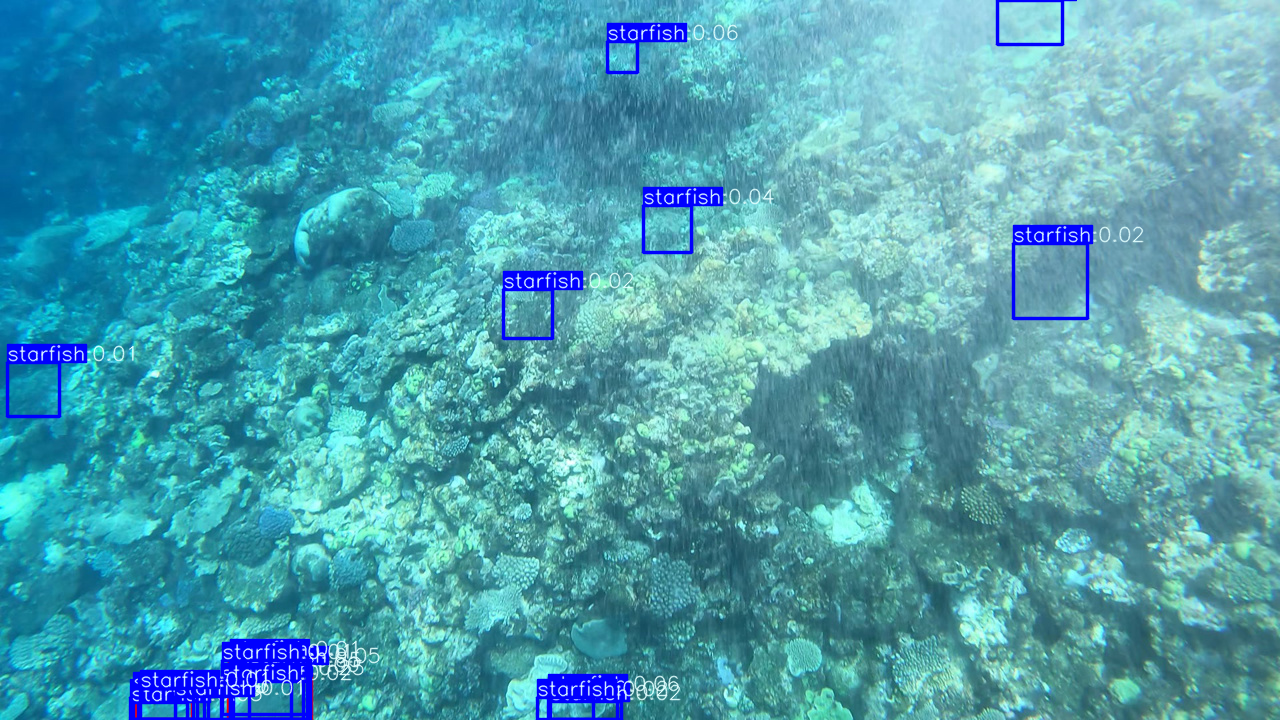

In [29]:
from IPython.display import display
i = 2500
test_image_path = image_paths[i]
img = cv2.imread(test_image_path)[...,::-1]


# bboxes, bbclasses, scores, img = tempt_yolov5_inference(model, img)
bboxes, confis = predict(model, img, size=IMG_SIZE, augment=AUGMENT)

print(ground_truth[i])
print(bboxes)

# # Draw Green ground truth box
# out_image = draw_yolov5_predictions(img, ground_truth[i], [1.0] * len(ground_truth[i]), [0] * len(ground_truth[i]), COCO_CLASSES, (0,255,0))
out_image = show_img(img, ground_truth[i],[1.0]*len(ground_truth[i]), bbox_format='coco', colors=[(255, 0, 0)]*(len(bboxes)))

# # Draw Red inference box
out_image = show_img(np.array(out_image), bboxes,confis, bbox_format='coco', colors=[(0,0,255)]*(len(bboxes)))

display(out_image)

In [30]:
# modified from: https://www.kaggle.com/code/alexchwong/stop-guessing-conf-systematically-evaluate-f2/notebook
# Confidence scores of true positives, false positives and count false negatives
TP = [] # Confidence scores of true positives
FP = [] # Confidence scores of true positives
FN = 0  # Count of false negative boxes

for i in range(len(image_paths)):
    test_image_path = image_paths[i]
    img = cv2.imread(test_image_path)
    img = cv2.imread(test_image_path)[...,::-1]
    bboxes, scores = predict(model, img, size=IMG_SIZE, augment=AUGMENT)

    # Test YOLOV5
    test_image = ground_truth[i]
    if len(bboxes) == 0:
        # all ground_truth are false negative
        FN += len(test_image)
    else:
        bb = bboxes.copy().tolist()
        for idx, b in enumerate(bb):
            b.append(scores[idx])
        bb.sort(key = lambda x: x[4], reverse = True)
        
        if len(test_image) == 0:
            # all bboxes are false positives
            for b in bb:
                FP.append(b[4])
        else:
            # match bbox with ground_truth
            for b in bb:
                matched = False
                for g in test_image:
                    # check whether ground_truth box is already matched to an inference bb
                    if len(g) == 4:
                        # g bbox is unmatched
                        if IOU_coco(b, g) >= eval_IOU:
                            g.append(b[4]) # assign confidence values to g; marks g as matched
                            matched = True
                            TP.append(b[4])
                            break
                if not matched:
                    FP.append(b[4])
            for g in test_image:
                if len(g) == 4:
                    FN += 1
print('success')

success


**Display metrics**

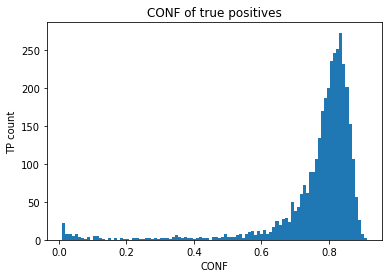

True positives = 3522
False negatives = 65


In [31]:
%matplotlib inline
plt.hist(TP, 100)
plt.title("CONF of true positives")
plt.xlabel('CONF')
plt.ylabel('TP count')
plt.show()

print(f'True positives = {len(TP)}')
print(f'False negatives = {FN}')

# F2 metric

**Take the average of F2 from different IOU**

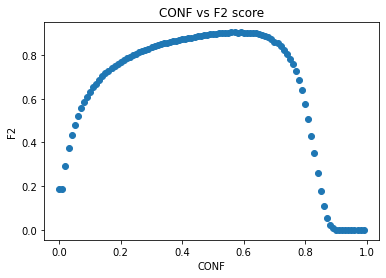

F2 max is 0.903790242067769 at CONF = 0.56


In [32]:
F2_list = []
F2_max = 0.0
F2_maxc = -1.0

for con in np.arange(0.0, 1.0, 0.01):
    FNcount = FN + sum(1 for i in TP if i < con)
    TPcount = sum(1 for i in TP if i >= con)
    FPcount = sum(1 for i in FP if i >= con)
    R = TPcount / (TPcount + FNcount + 0.0001)
    P = TPcount / (TPcount + FPcount + 0.0001)
    F2 = (5 * P * R) / (4 * P + R + 0.0001)
    F2_list.append((con, F2))
    if F2_max < F2:
        F2_max = F2
        F2_maxc = con

plt.scatter(*zip(*F2_list))
plt.title("CONF vs F2 score")
plt.xlabel('CONF')
plt.ylabel('F2')
plt.show()

print(f'F2 max is {F2_max} at CONF = {F2_maxc}')

**From W&B**

**Metrics （Results against Epoches）**

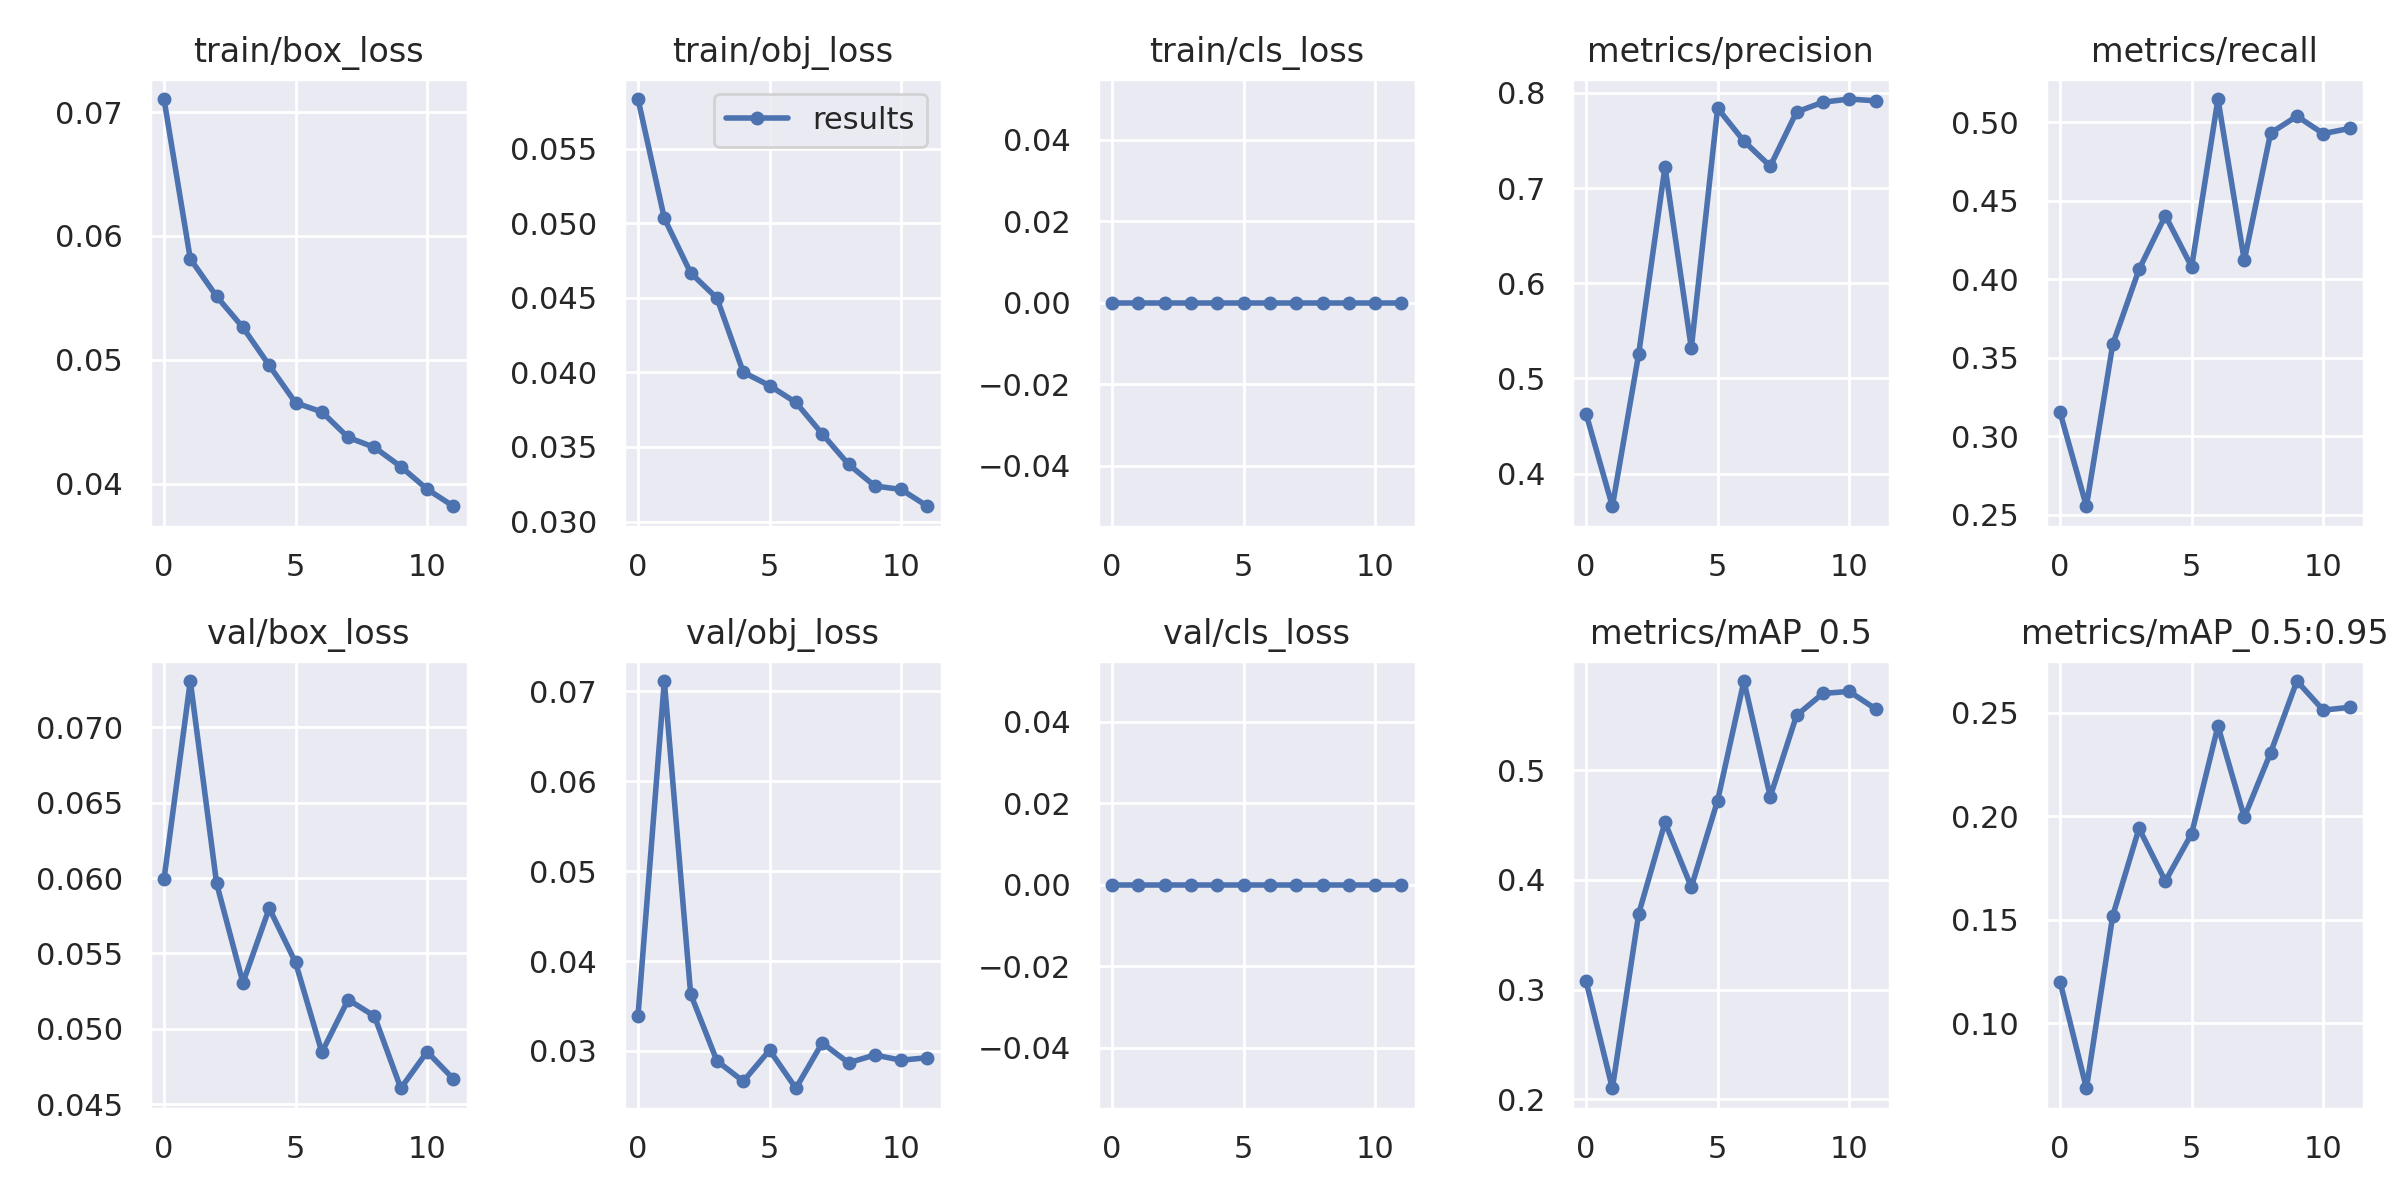

In [37]:
# display(Image.open('/kaggle/input/cots-results/cots_result/metric.png')) 

**Validation batch images**

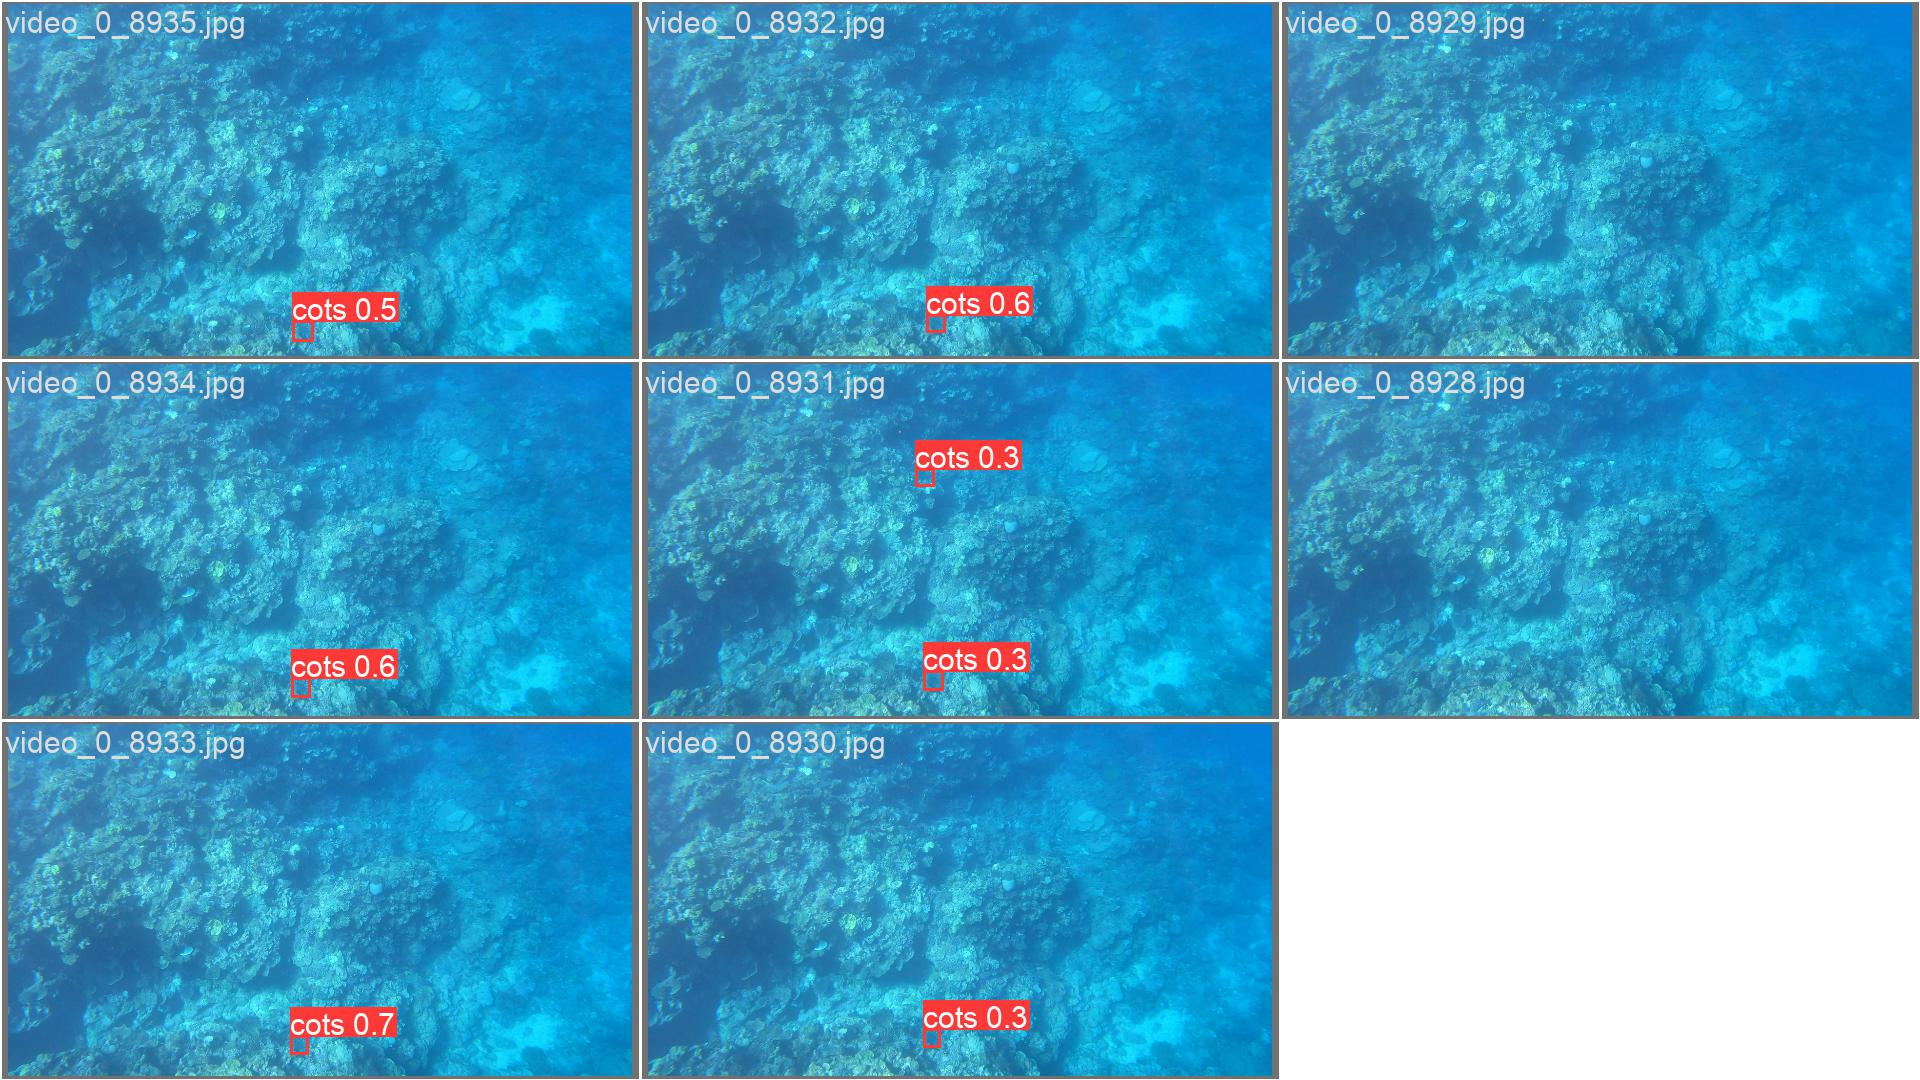

In [38]:
display(Image.open('/kaggle/input/cots-results/cots_result/valid.jpg') )

**Confusion matrix**

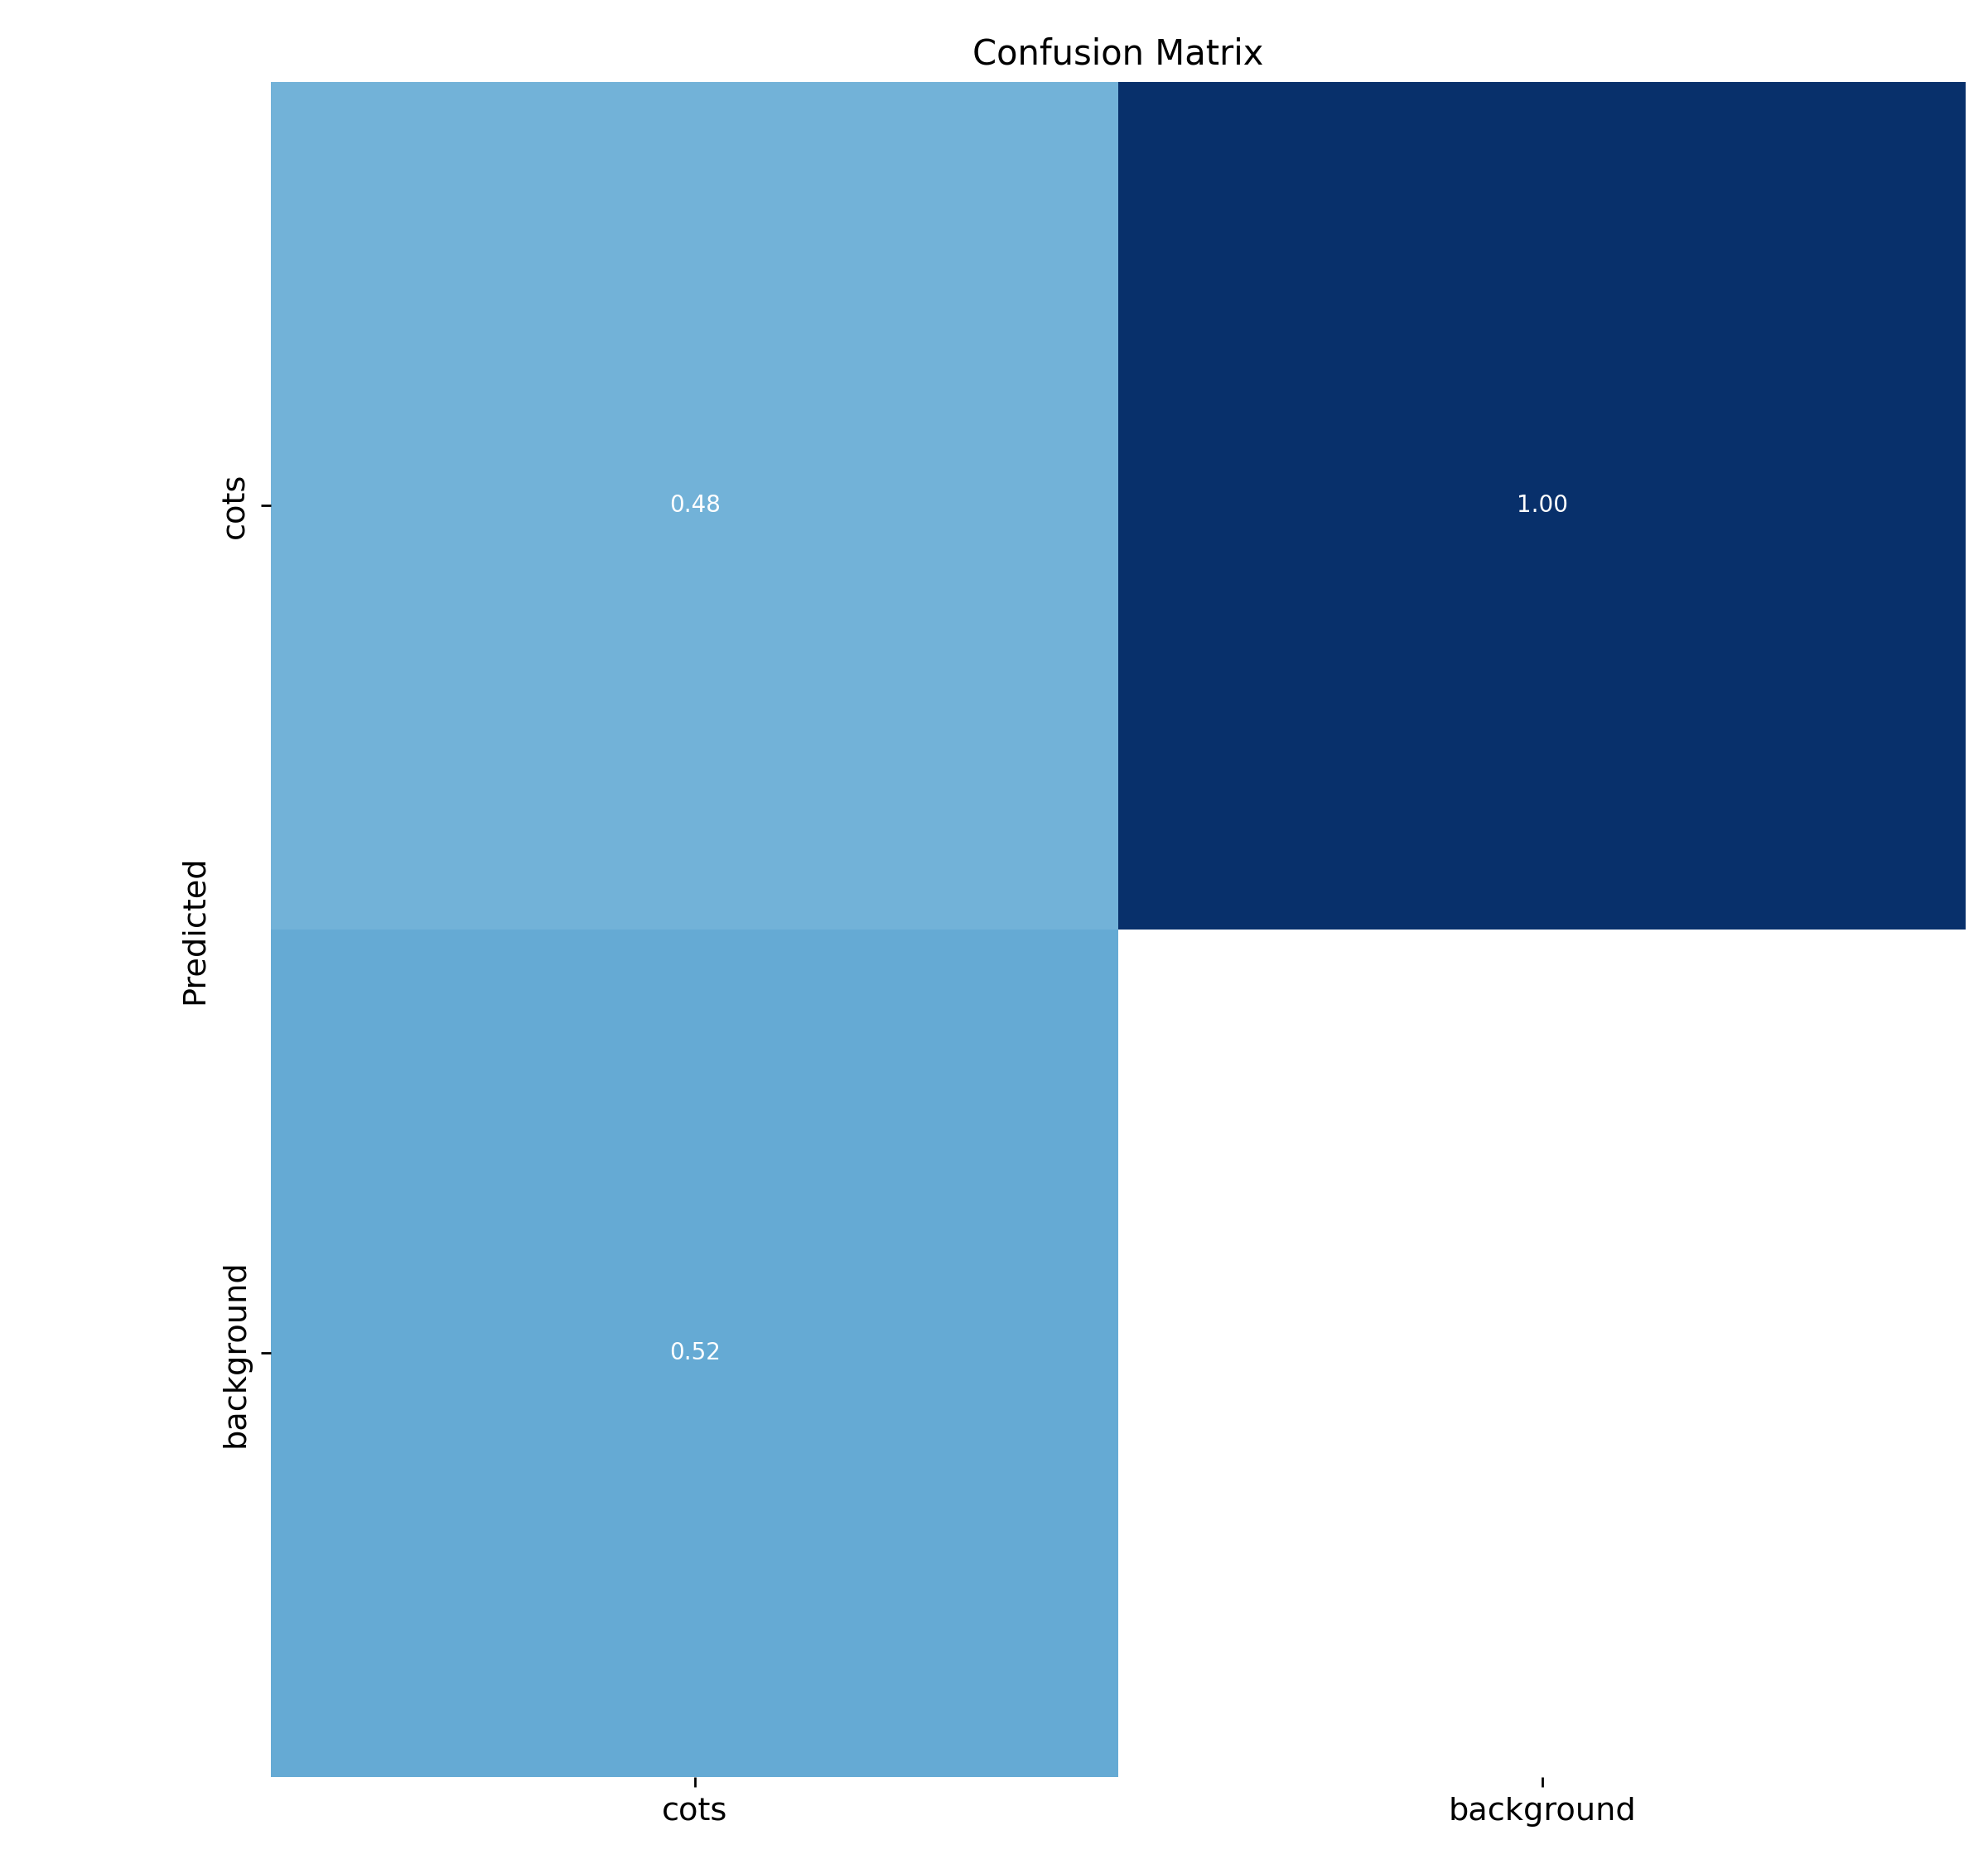

In [39]:
# display(Image.open('/kaggle/input/cots-results/cots_result/confusion_matrix.png') )

**Labels**

It represents the occurrence of sizes of labels with respect to width and height for the four images at the bottom. The upper one image shows the size of labels in x and y

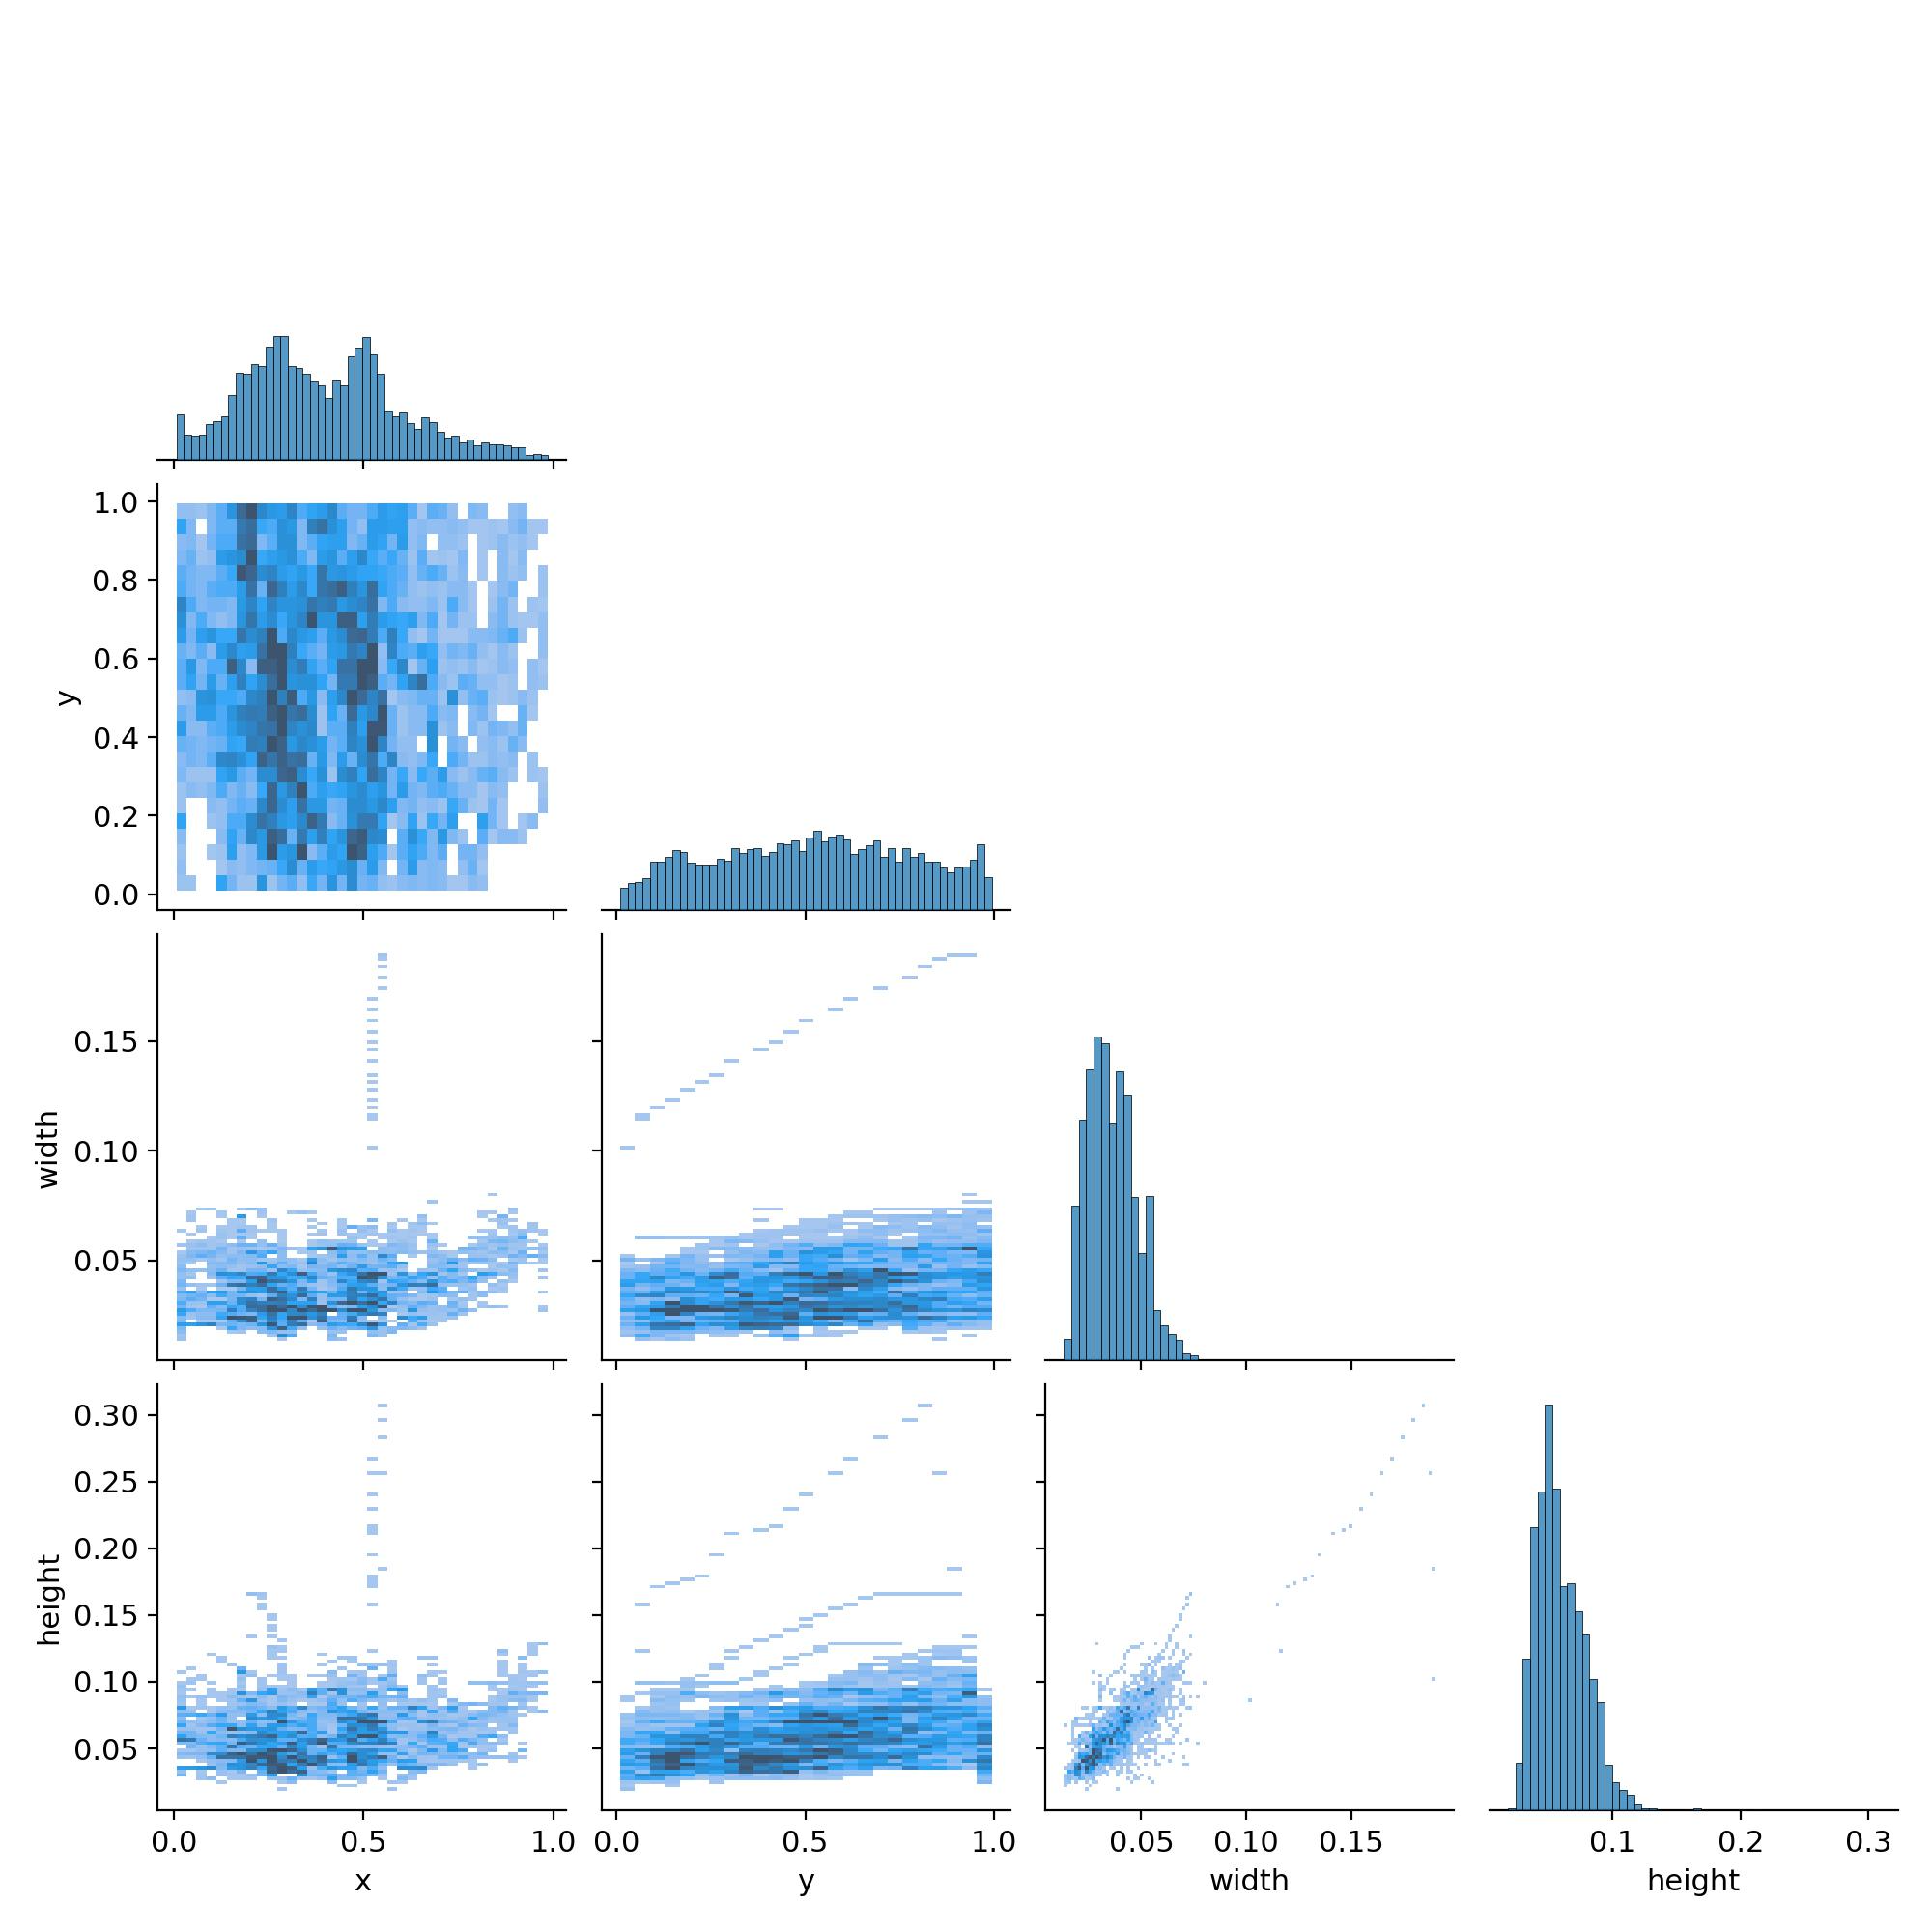

In [40]:
# display(Image.open('/kaggle/input/cots-results/cots_result/Labels.jpg') )

**P curve**

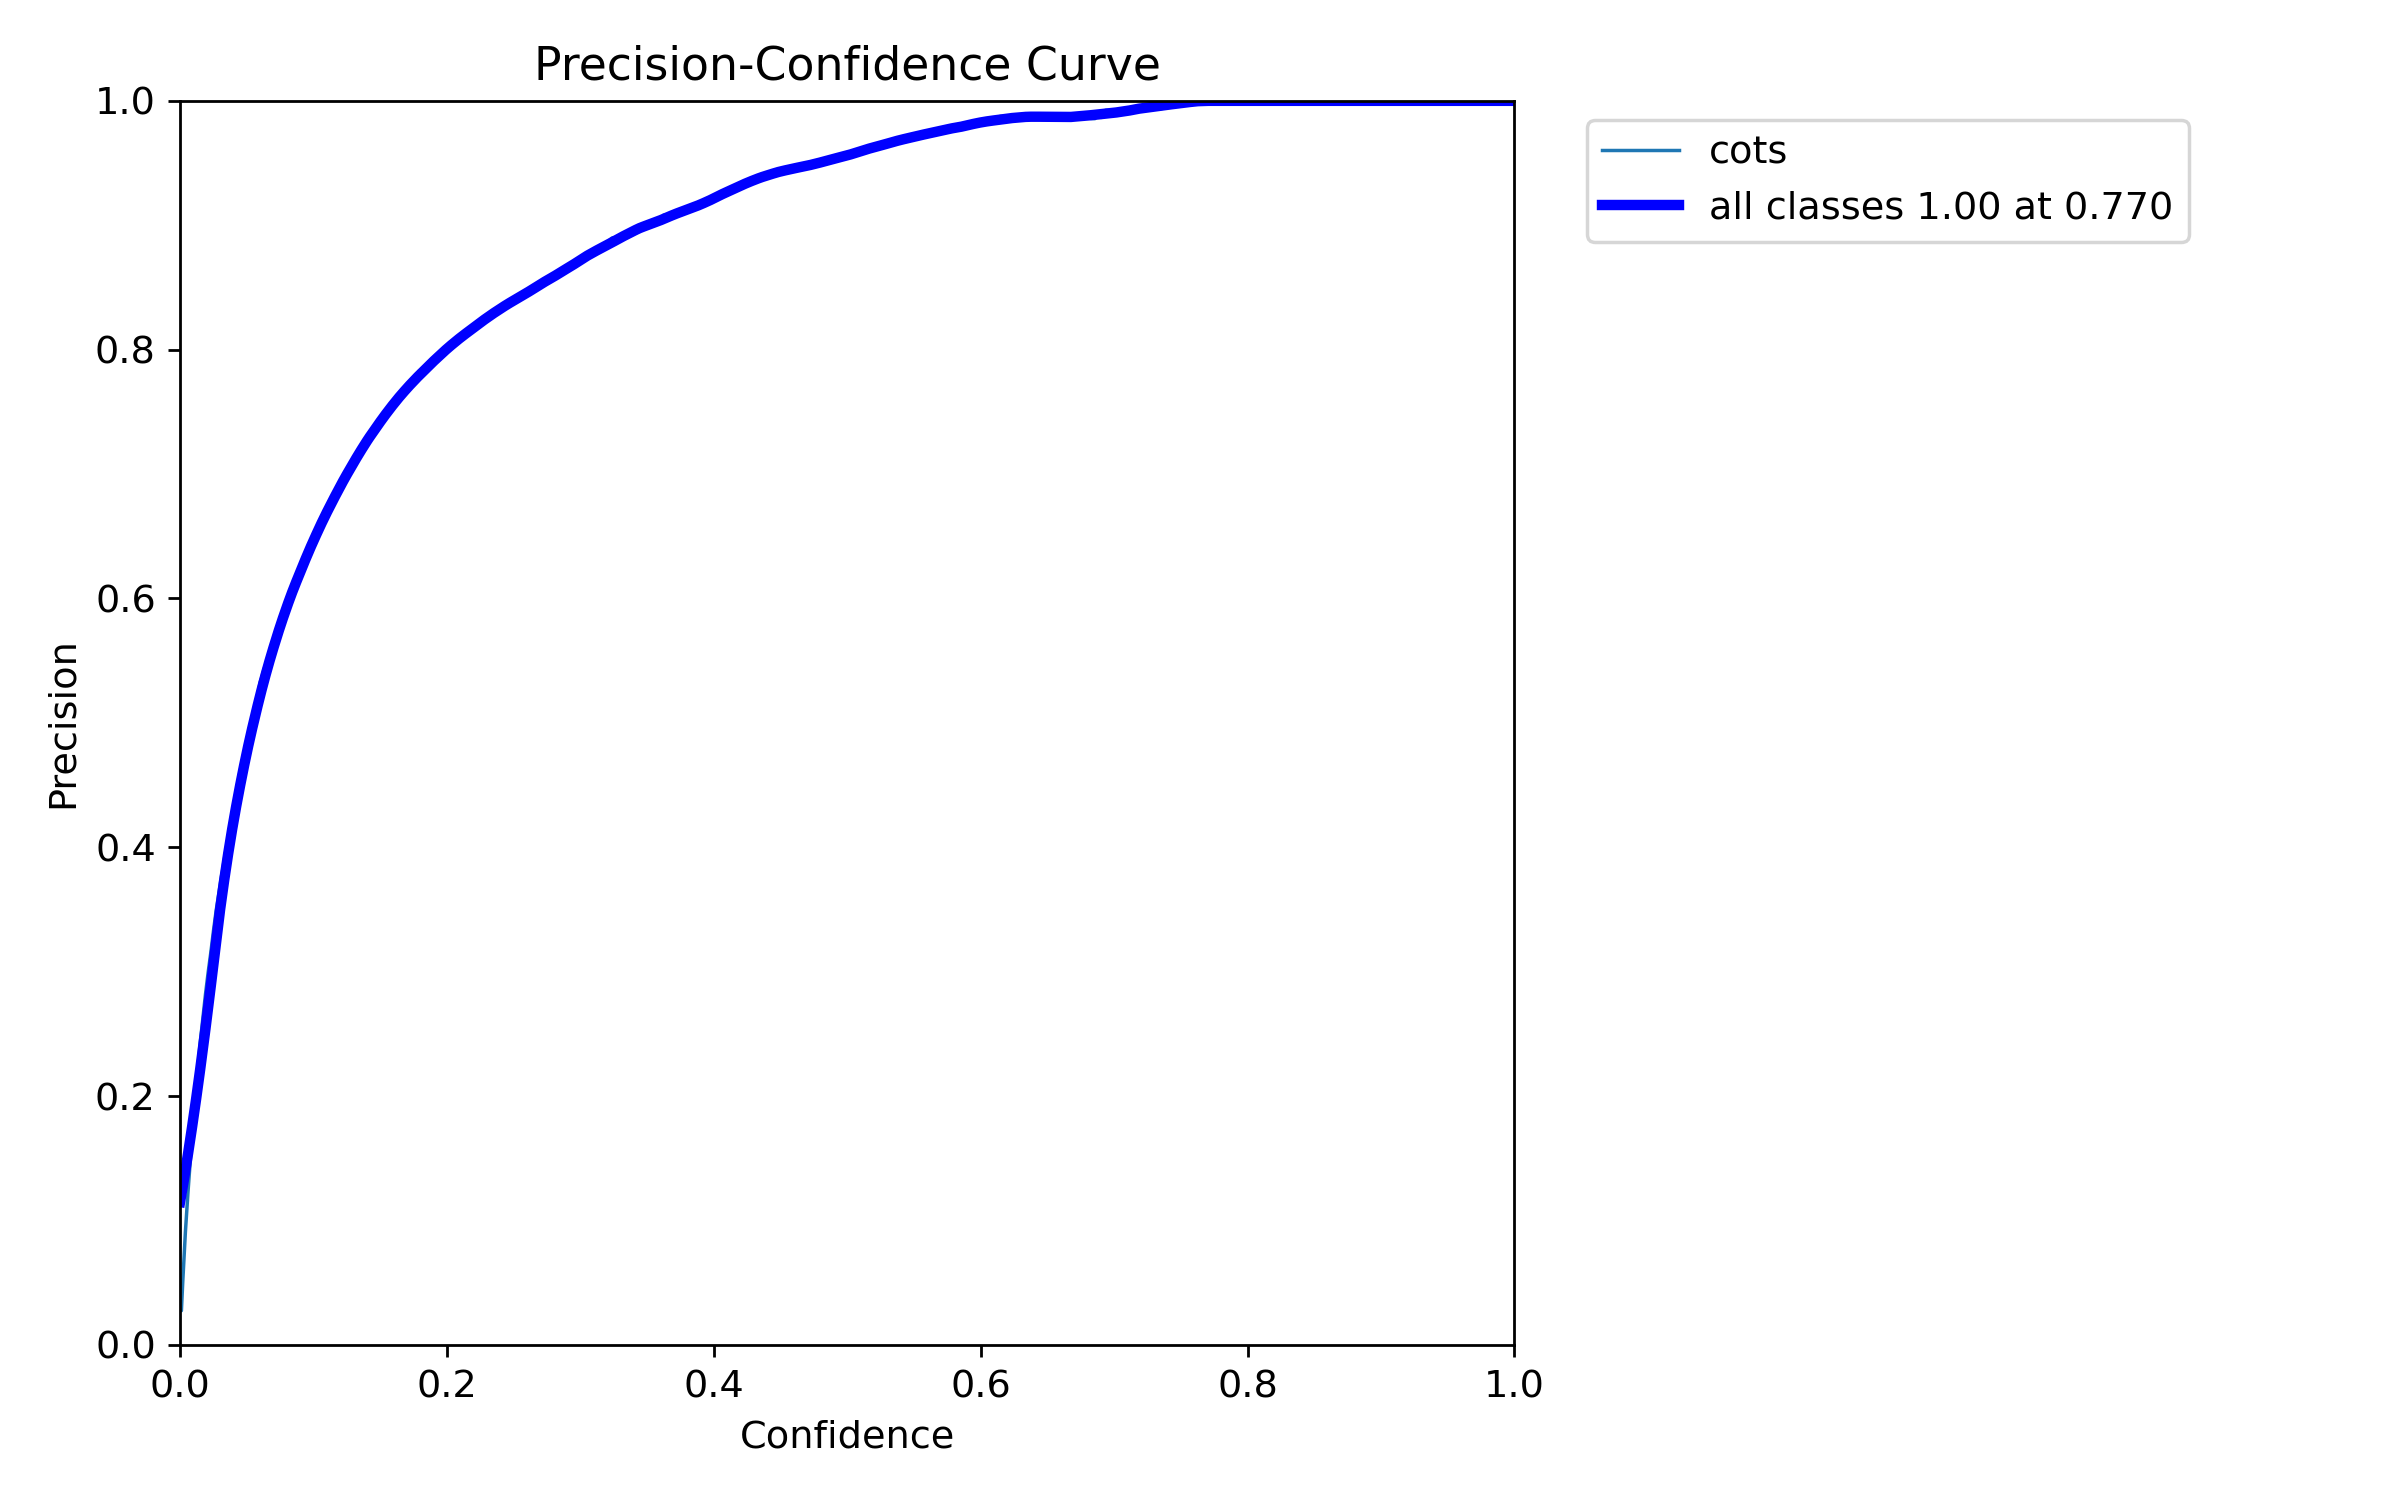

In [41]:
# display(Image.open('/kaggle/input/cots-results/cots_result/P_curve.png') )

**R curve**

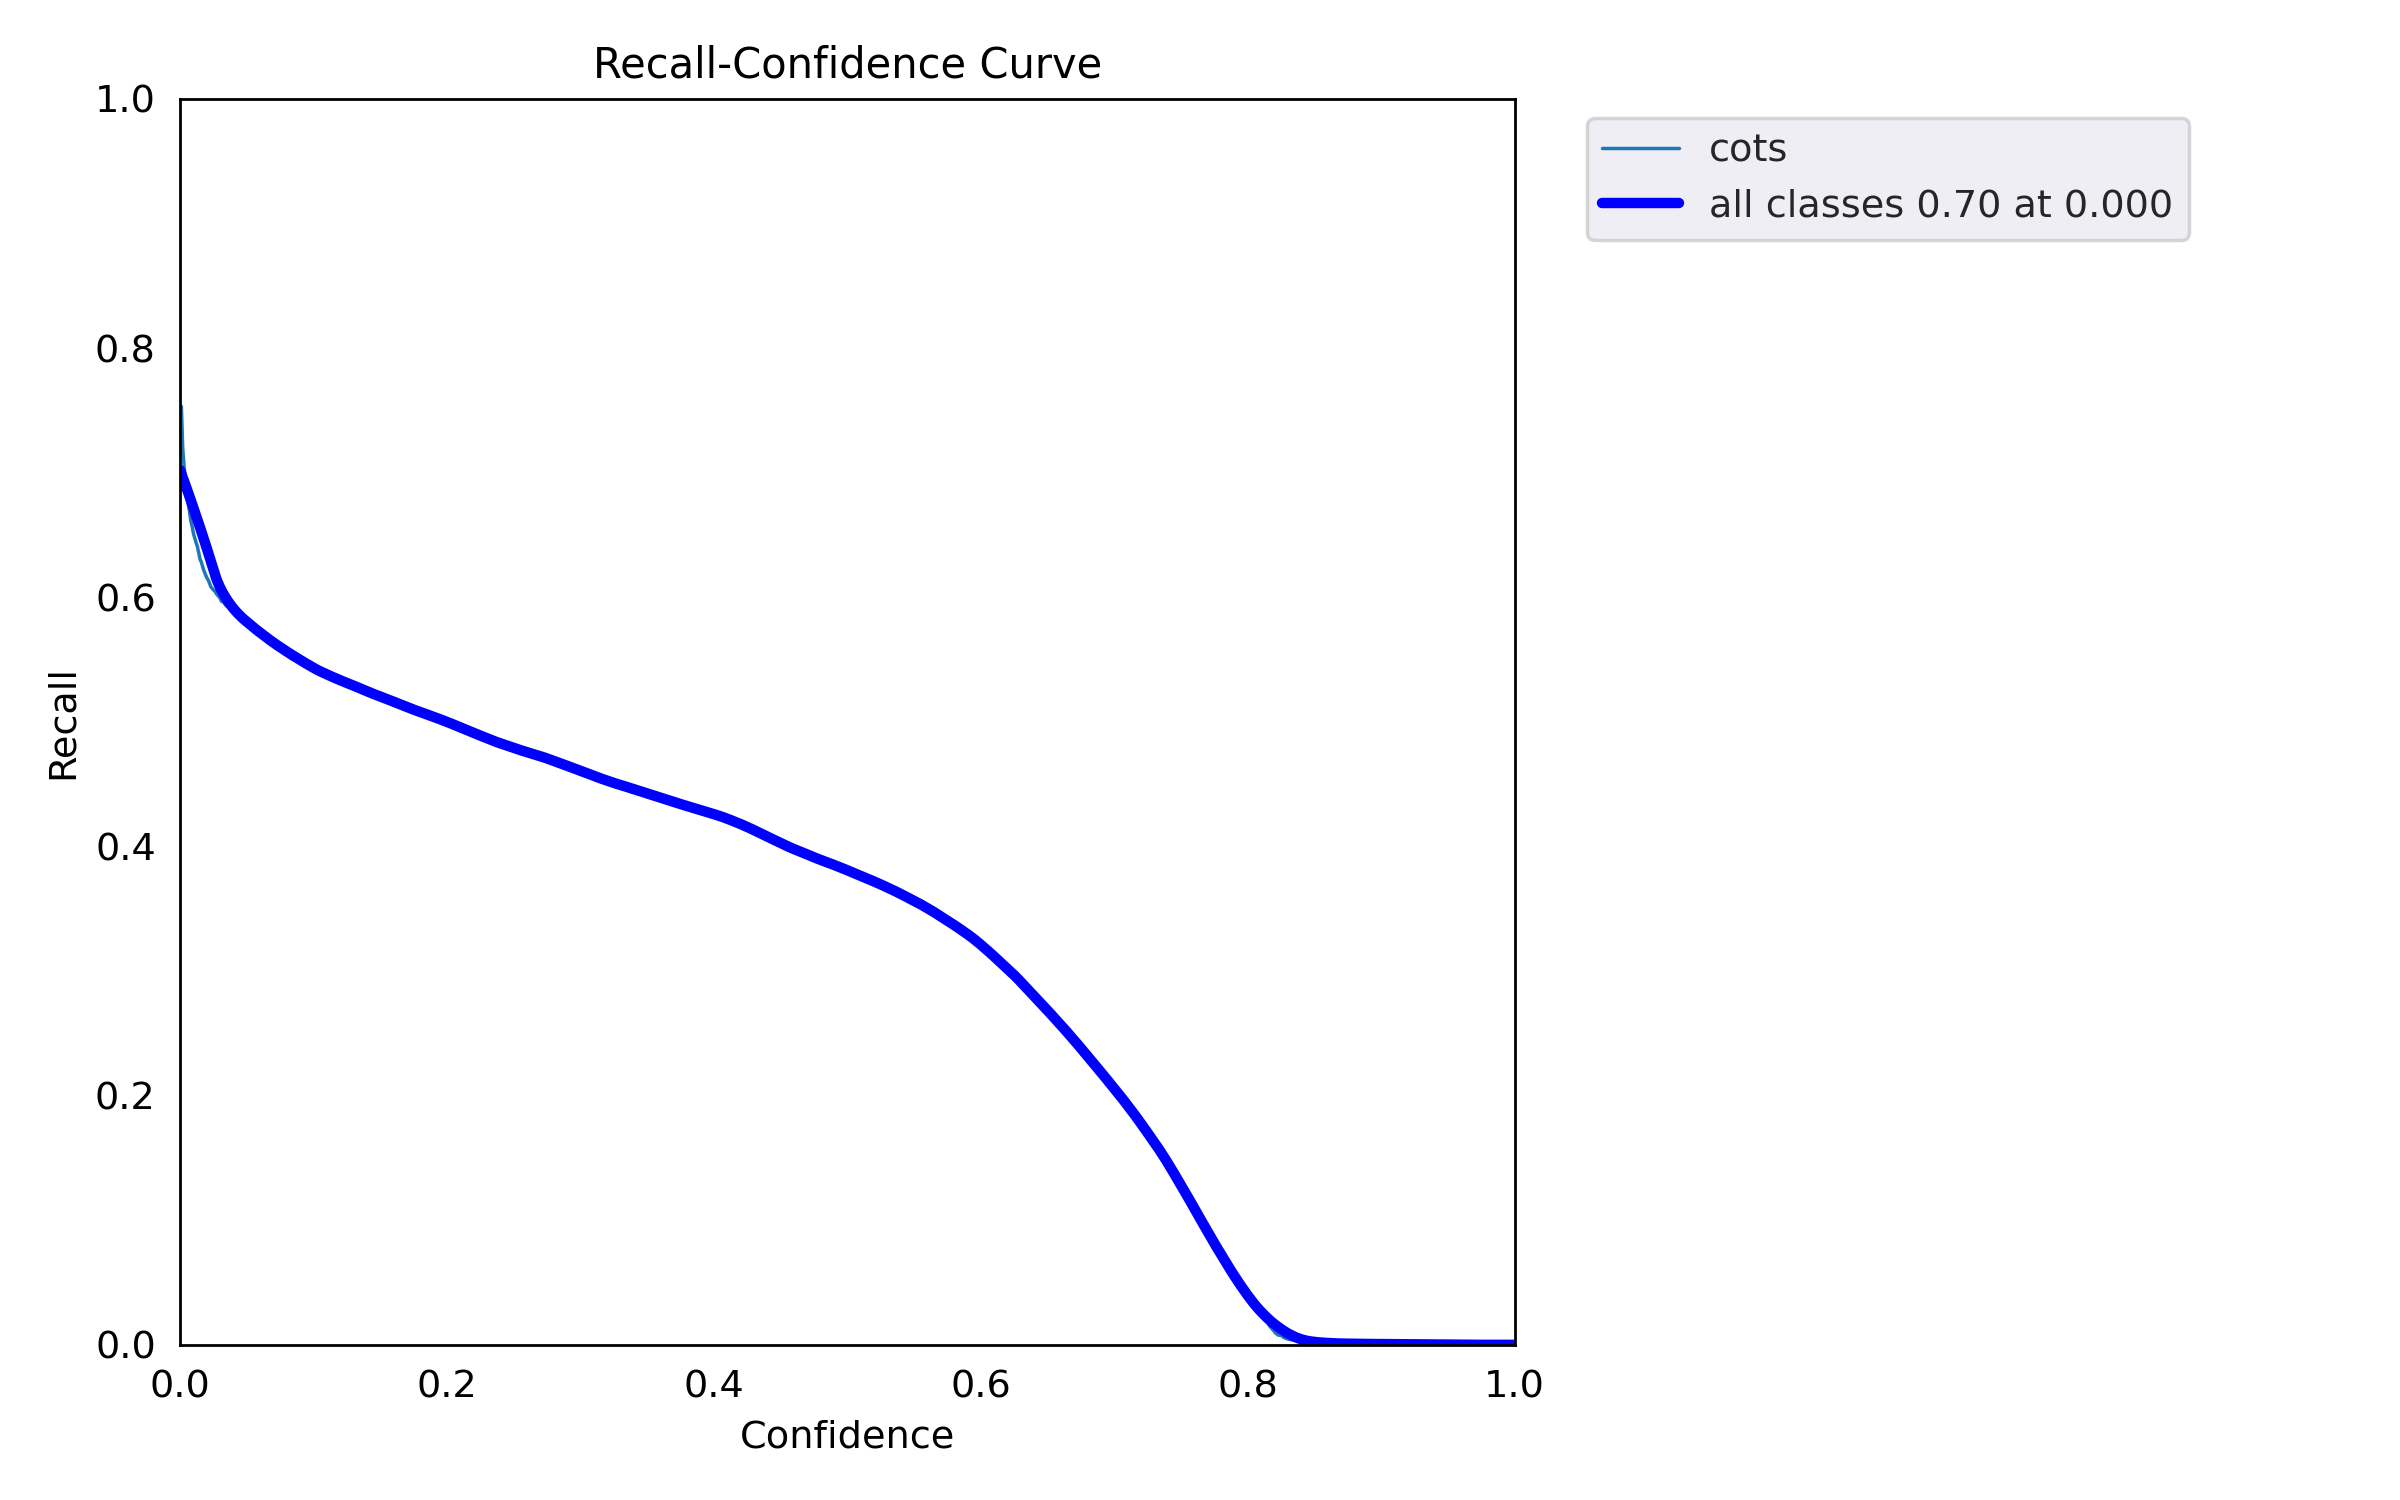

In [42]:
# display(Image.open('/kaggle/input/cots-results/cots_result/R_curve.png'))

**PR curve**

It shows the tradeoff between precision and recall.

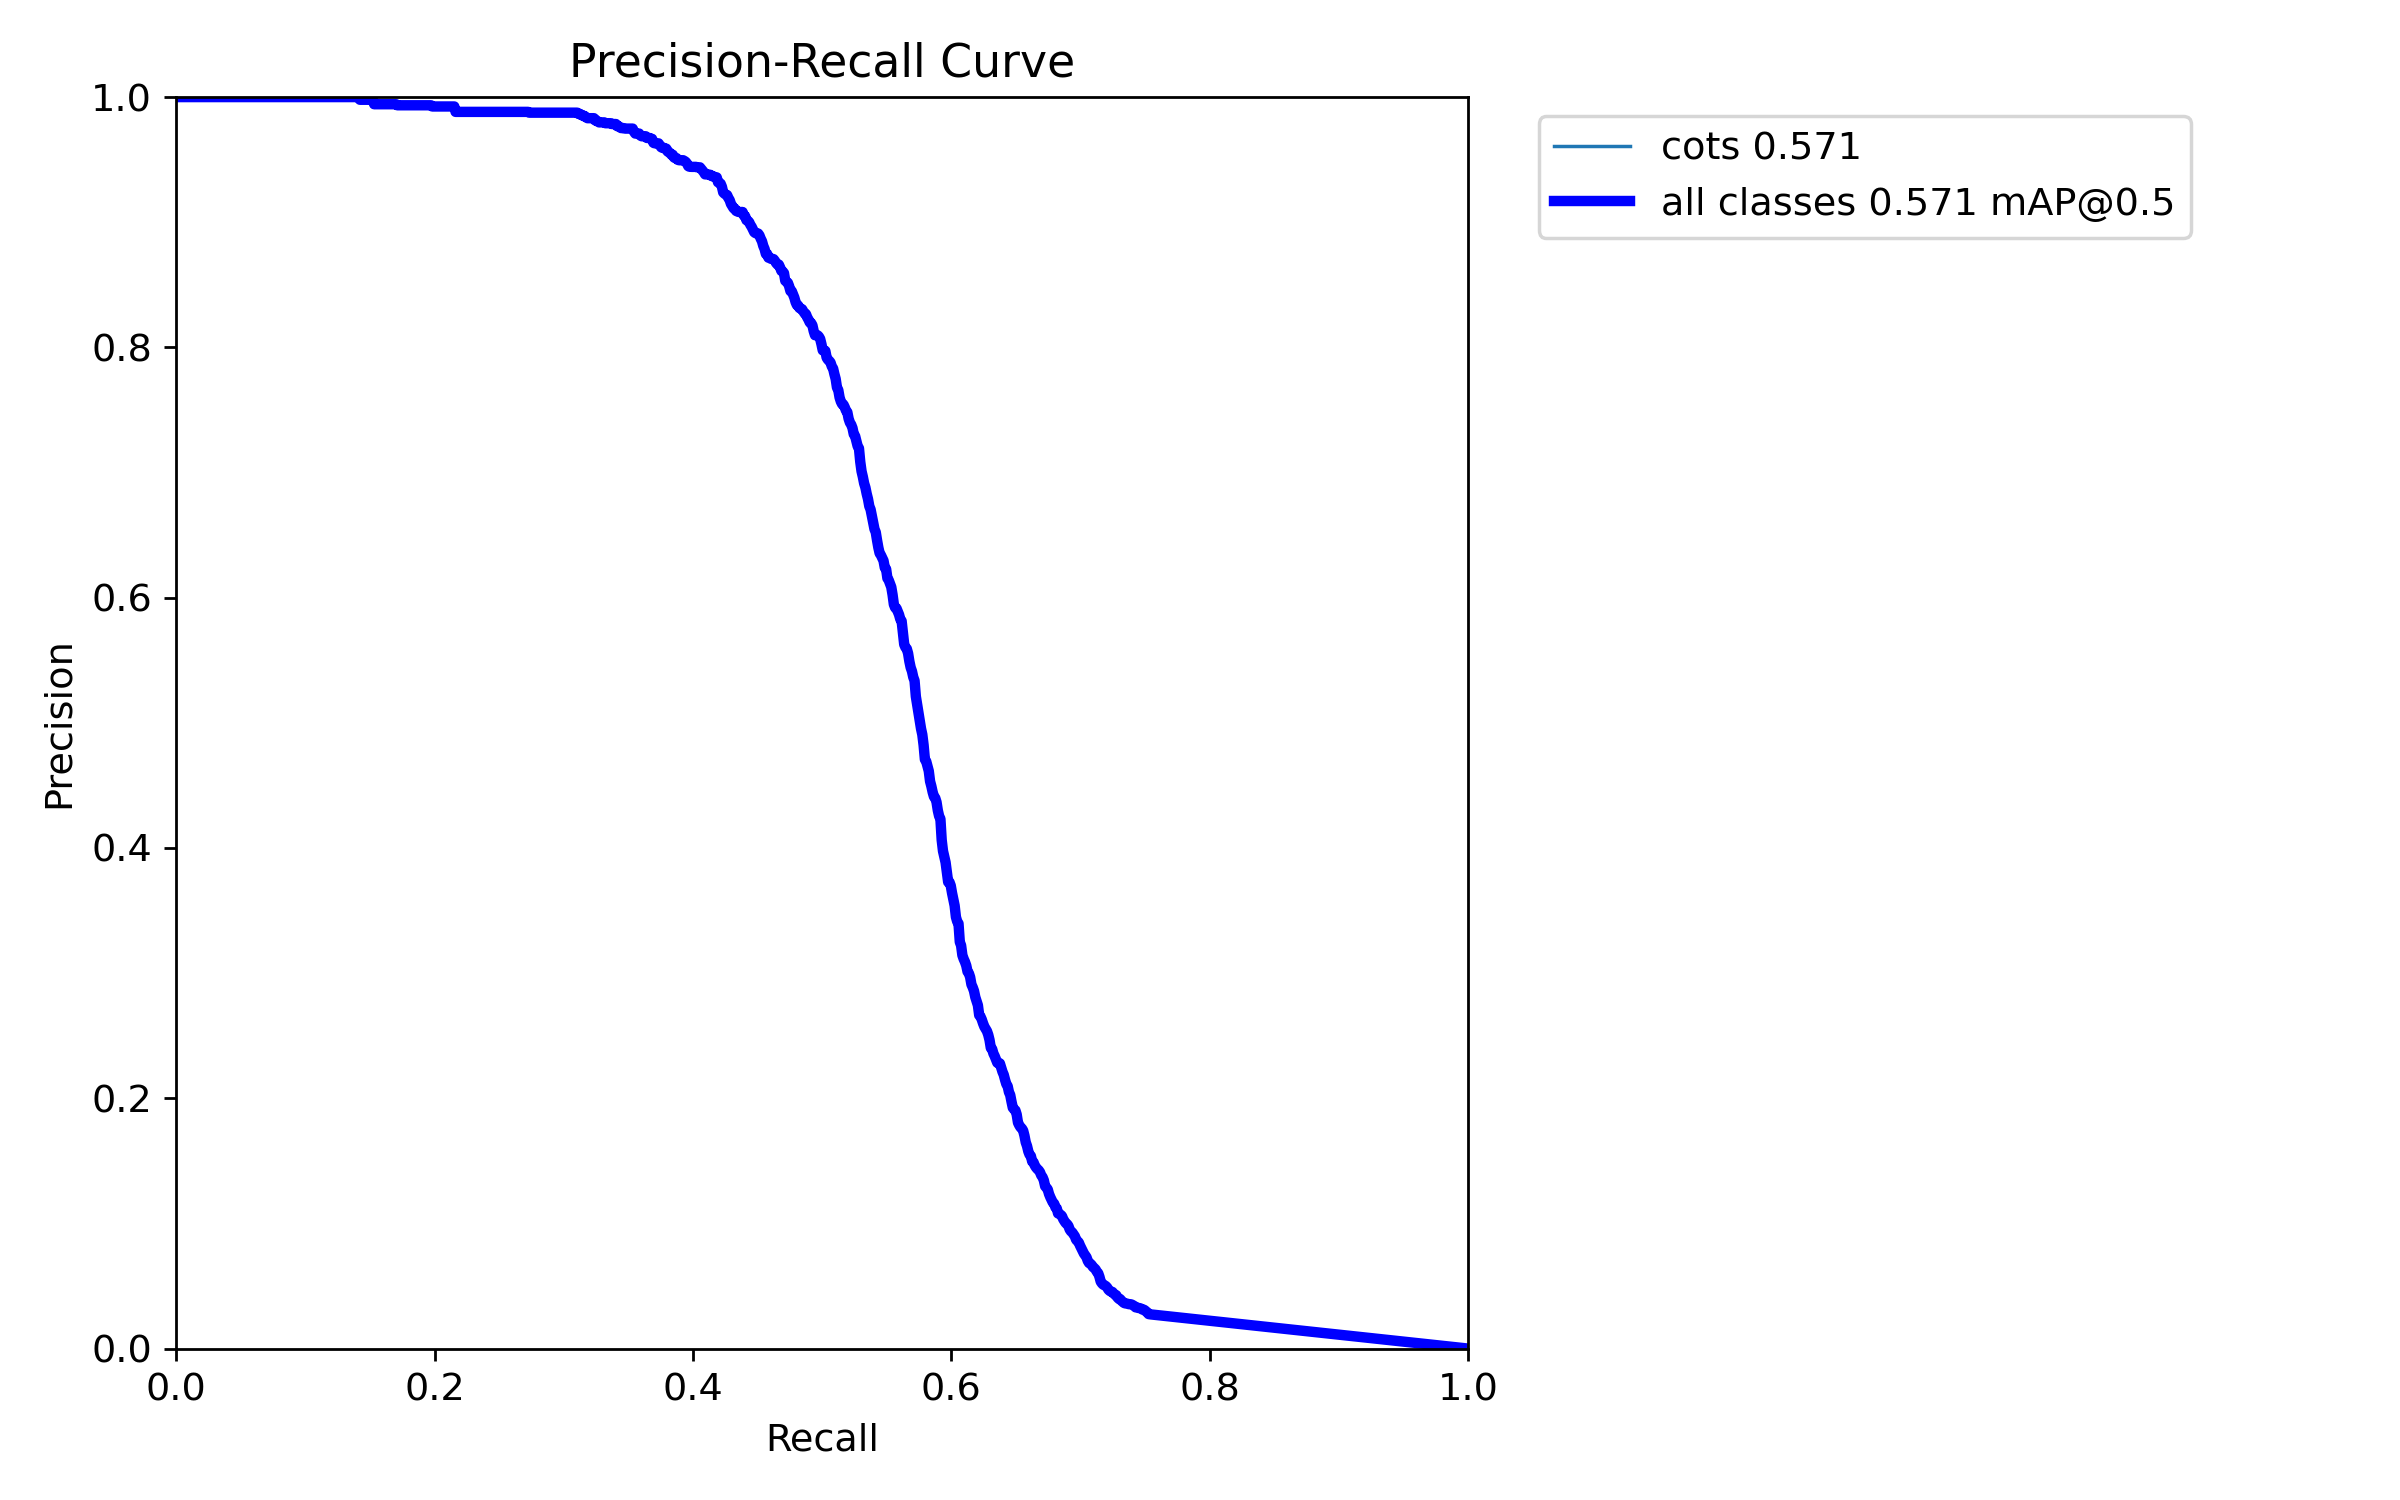

In [43]:
# display(Image.open('/kaggle/input/cots-results/cots_result/PR_curve.png'))

**F1 curve**

It balances the precision and recall. 

F1 = (2*precision*recall)/(precision+recall)

However, in this case, the F2 score are used.

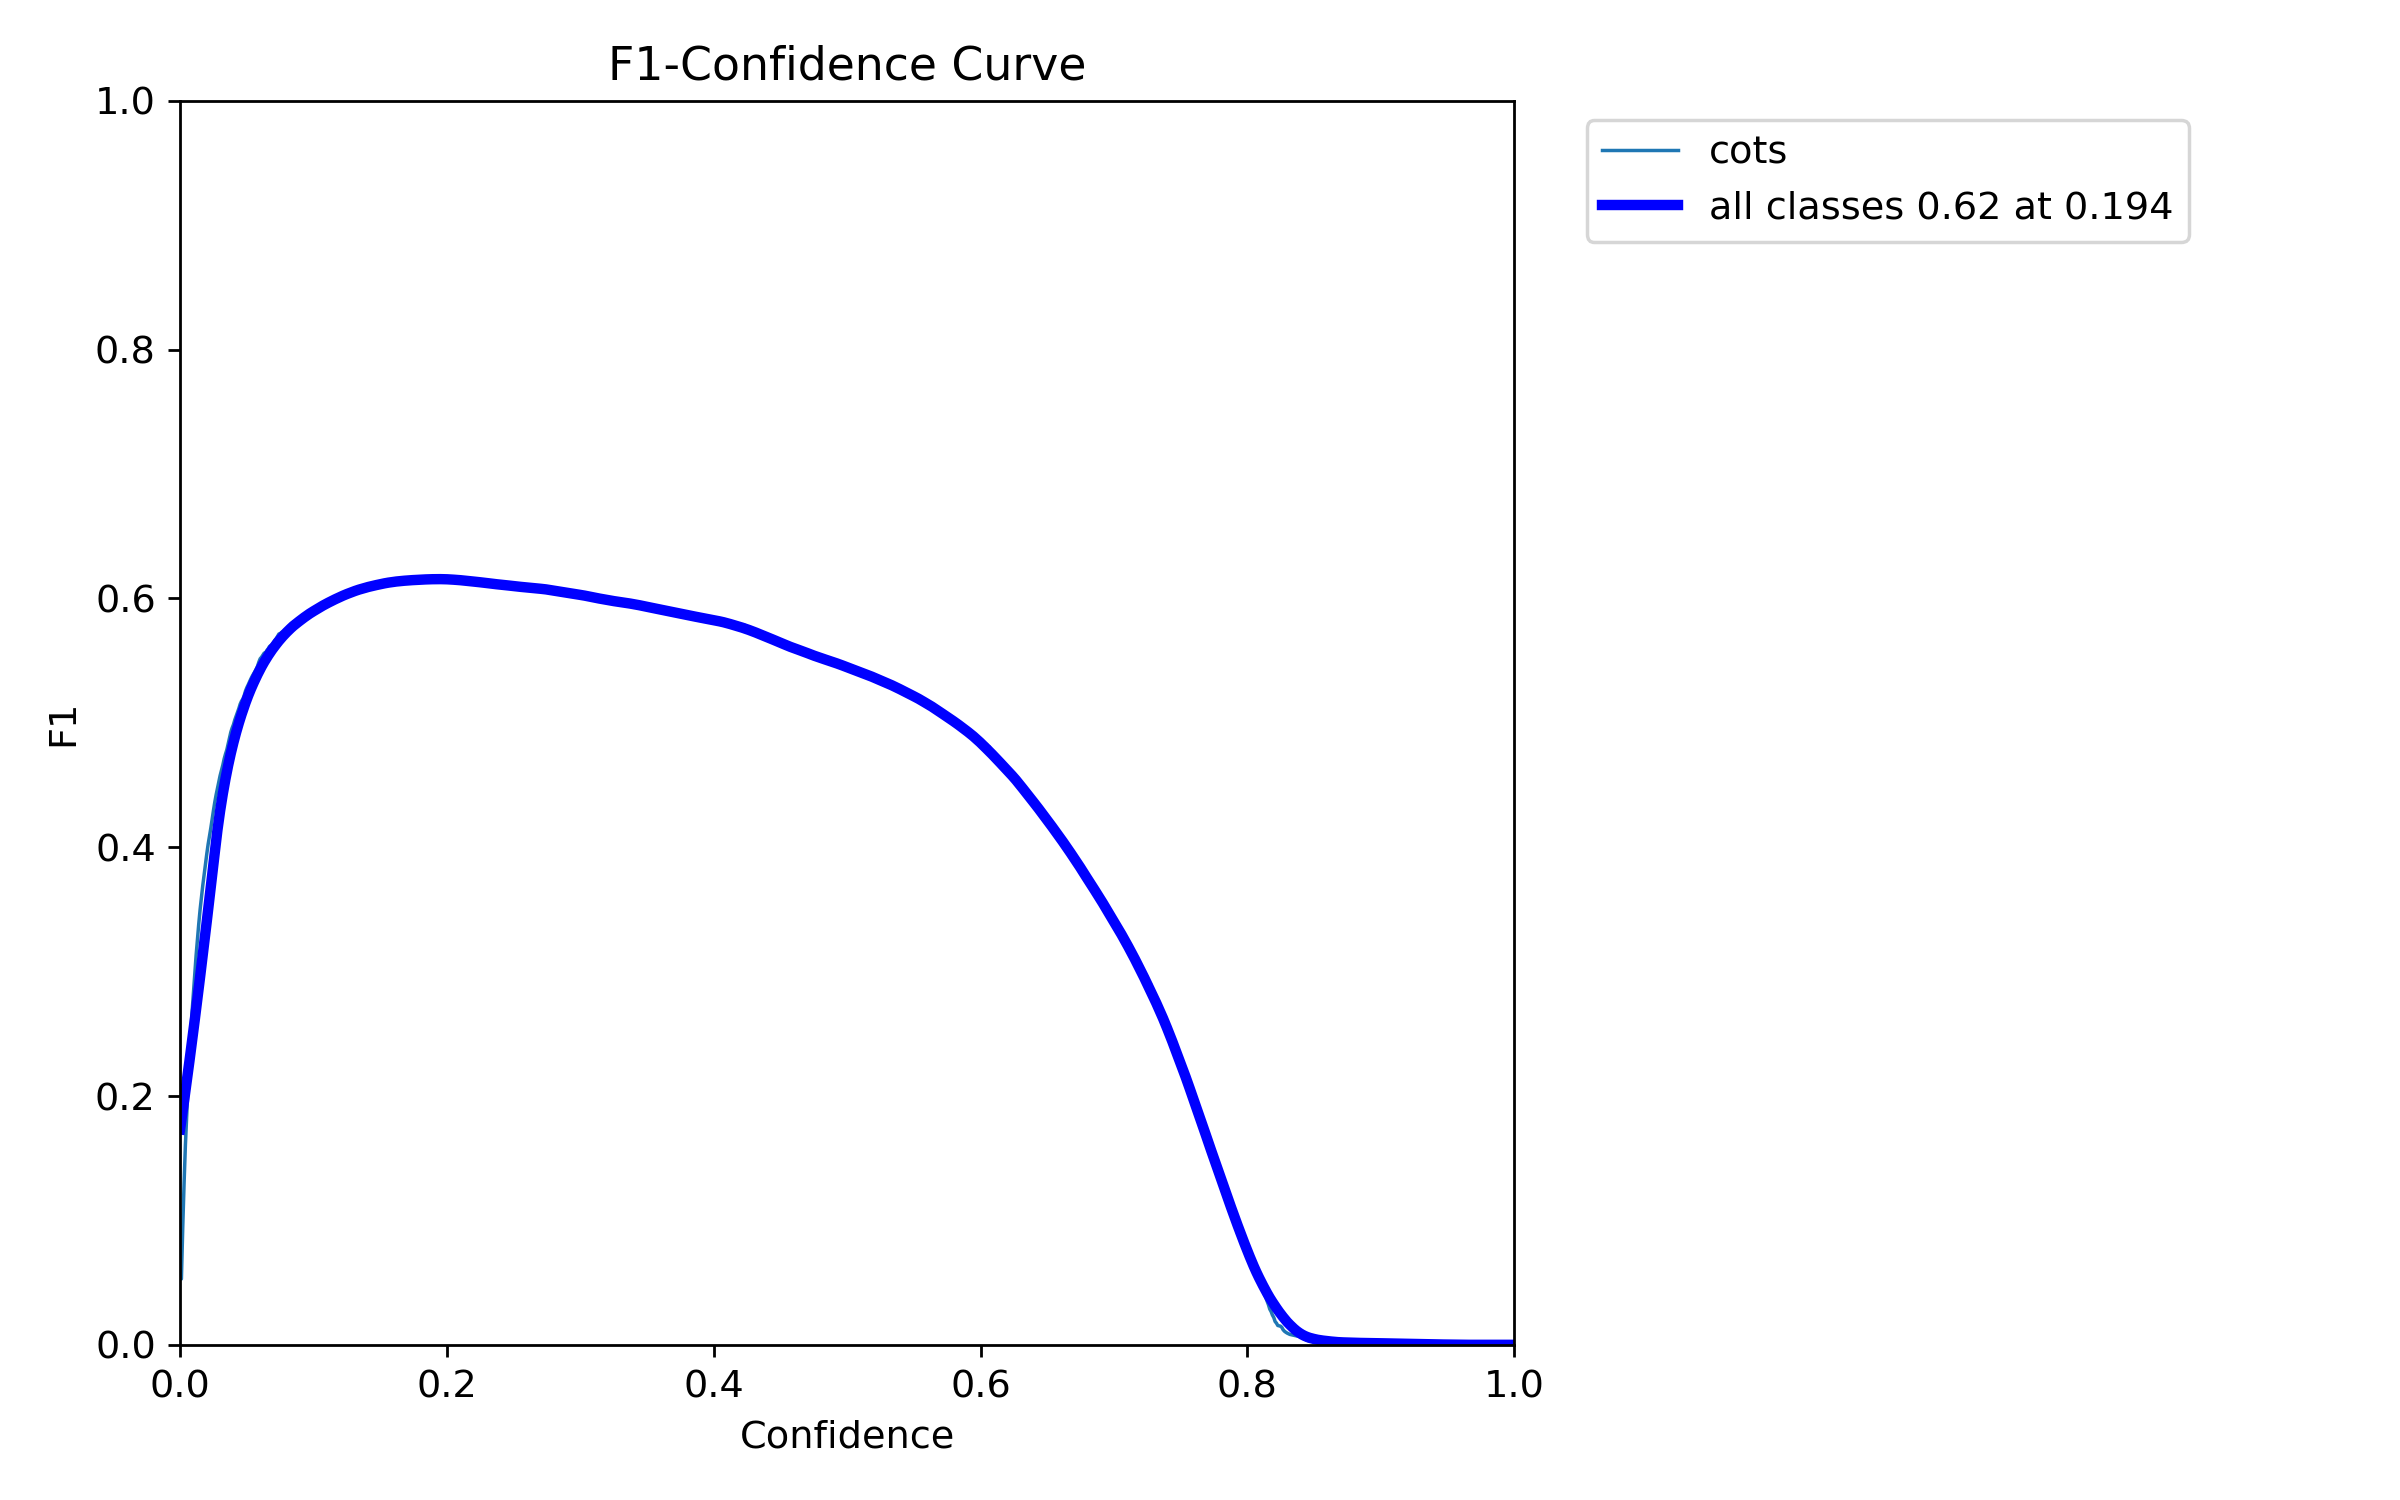

In [44]:
# display(Image.open('/kaggle/input/cots-results/cots_result/F1_curve.png') )